**Evaluating GOES images with coincident MODIS and ASTER**

What are the magnitude and distribution of differences between ABI-ASTER & MODIS-ASTER?
* Is there an East-to-West change in differences?
* Is there a North-to-South change in differences?
* Is there a relationship between differences and elevation, slope, or aspect?
* Is there a relationship between differences and fractional vegetation covered area?
* Is there a relationship between differences and fractional snow covered area? (from coincident MODIS)

In [1]:
import xarray as xr
from xhistogram.xarray import histogram
import richdem as rd
import rioxarray as rxr
import xrspatial as xrs
import numpy as np
import pandas as pd
import geopandas as gpd
import glob
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

import pysolar
import datetime

from asp_binder_utils import get_dem

/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/osgeo/gdal.py:107: DeprecationWarning: gdal.py was placed in a namespace, it is now available as osgeo.gdal
  DeprecationWarning)


In [2]:
import warnings
warnings.filterwarnings('ignore')

Define functions

In [3]:
def summary_stats(a, b):
    '''Compute summary statistics for the difference between two sets.
    Input two flattened (1-D) arrays with NaN values removed'''
    
    # remove nan values
    a = a[np.isnan(a)==False]
    b = b[np.isnan(b)==False]
    
    # for difference stats
    diff = b - a
    
    # for linear regression stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(a, b)
    
    # populate dict with summary stats
    summary_stats_dict = {
        #'diff' : diff ,
        'n' : len(diff) ,
        'mean_diff' : np.nanmean( diff ),
        'median_diff' : np.nanmedian( diff ),
        'mean_squared_diff' : np.nanmean( diff**2 ),
        'rms_diff' : np.sqrt( np.nanmean( diff**2 ) ),
        'std_diff' : np.nanstd( diff ),
        'slope' : slope,
        'intercept' : intercept,
        'r_value' : r_value,
        'p_value' : p_value,
        'std_err' : std_err
        }
    
    return summary_stats_dict

In [4]:
def plot_regression_confidence_intervals(_x,_y,conf):

    # linear regression
    slope, intercept, r, p, se = stats.linregress(_x, _y)
    
    # predict y values of origional data using the fit
    p_y = slope*_x + intercept
    
    # calculate the y-error (residuals)
    y_err = _y - p_y
    
    # create series of new test x-values to predict for
    p_x = np.arange(np.min(_x),np.max(_x)+1,1)
    
    # now calculate confidence intervals for new test x-series
    mean_x = np.mean(_x)                 # mean of x
    n = _x.size                          # number of samples in original fit
    t = stats.t.ppf(conf, n-2)            # find the appropriate t value (for n-2, and two tailed 95%)        
    sse = np.sum(y_err**2)              # sum of the squares of the residuals
    st_err = np.sqrt(sse/(n-2))         # standard error
    
    sigma = st_err**2 * (1 + 1/n + ( ( n*(p_x-mean_x)**2 ) / ( n*np.sum(_x**2) - np.sum(_x)**2 ) ) )
    confs = t * np.sqrt(sigma)
    
    # now predict y based on test x-values
    p_y = slope*p_x + intercept
    
    # get lower and upper confidence limits based on predicted y and confidence intervals
    lower = p_y - np.abs(confs)
    upper = p_y + np.abs(confs)
    
    # plot line of best fit
    c_x = np.array([_x.min(),_x.max()])
    c_y = slope*c_x + intercept
    plt.plot(c_x,c_y,'r--',label='Regression line')
    
    # plot confidence limits
    plt.plot(p_x,lower,':',c='grey',label='Lower confidence limit (95%)')
    plt.plot(p_x,upper,':',c='grey',label='Upper confidence limit (95%)')

In [5]:
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


Set up working area geometry

In [6]:
# Larger area around Tuolumne further south and east to include Mammoth
(utm_e_UL, utm_n_UL) = 282500, 4205000
(utm_e_UR, utm_n_UR) = 305000, 4205000
(utm_e_LR, utm_n_LR) = 327500, 4160000
(utm_e_LL, utm_n_LL) = 305000, 4160000

geometry = [
    {
        'type': 'Polygon',
        'coordinates': [[
            [utm_e_UL, utm_n_UL],
            [utm_e_UR, utm_n_UR],
            [utm_e_LR, utm_n_LR],
            [utm_e_LL, utm_n_LL]
        ]]
    }
]

---
---
## Open dataset

In [7]:
ds = xr.open_dataset('/storage/spestana/ASTER-MODIS-GOES-DEM-FVEG-FSCA_v5_orthorectified.nc')
ds = ds.rio.clip(geometry)

In [8]:
ds

<xarray.Dataset>
Dimensions:                          (time: 27, x: 499, y: 500)
Coordinates:
  * y                                (y) float64 4.16e+06 4.16e+06 ... 4.205e+06
  * x                                (x) float64 2.826e+05 ... 3.274e+05
  * time                             (time) datetime64[ns] 2017-04-21T18:51:07 ... 2020-04-13T18:51:17
    band                             int64 1
    spatial_ref                      int64 0
Data variables:
    ast_goes_aster_rad               (time, y, x) float64 nan nan ... nan nan
    ast_goes_goes_rad                (time, y, x) float32 nan nan ... nan nan
    ast_goes_goes_tb                 (time, y, x) float32 nan nan ... nan nan
    ast_goes_goes_zones              (time, y, x) float64 nan nan ... nan nan
    ast_goes_mean_rad                (time, y, x) float64 nan nan ... nan nan
    ast_goes_max_rad                 (time, y, x) float64 nan nan ... nan nan
    ast_goes_min_rad                 (time, y, x) float64 nan nan ... nan n

---

### Make two zonal categories, based on fveg

1) fveg > 0.5 or median fveg

2) fveg < 0.5 or median fveg

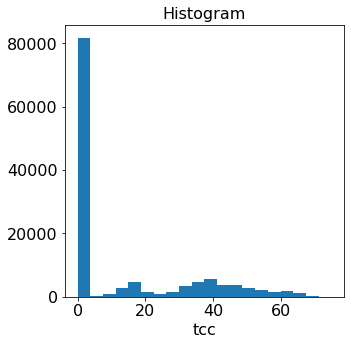

In [9]:
plt.figure(figsize=(5,5))
ds.tcc.plot.hist(bins=20);

333445 342185
667318 683829


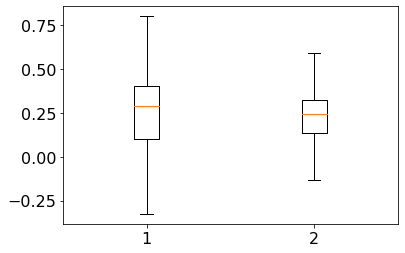

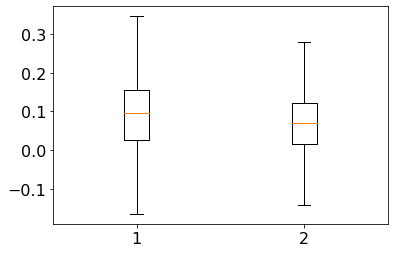

In [10]:
k = ds.fveg.quantile(0.5, dim=('x','y'))


#n=7
#ds.isel(time=n).ast_goes_mean_diff_rad.plot(cmap='RdBu_r', vmin=-10, vmax=10, figsize=(15,12))
#ds.fveg.where(ds.fveg>k).isel(time=n).plot(cmap='Greens',add_colorbar=False)




# Group A:
group_a = ds.where(ds.fveg > k).where(ds.time.dt.hour > 12).ast_goes_mean_diff_rad.values.ravel()
group_a = group_a[~np.isnan(group_a)]
# Group B:
group_b = ds.where(ds.fveg <= k).where(ds.time.dt.hour > 12).ast_goes_mean_diff_rad.values.ravel()
group_b = group_b[~np.isnan(group_b)]


print(len(group_a),len(group_b))
plt.figure()
plt.boxplot([group_a, 
             group_b], showfliers=False);



# Group A:
group_a = ds.where(ds.fveg > k).where(ds.time.dt.hour < 12).ast_goes_mean_diff_rad.values.ravel()
group_a = group_a[~np.isnan(group_a)]
# Group B:
group_b = ds.where(ds.fveg <= k).where(ds.time.dt.hour < 12).ast_goes_mean_diff_rad.values.ravel()
group_b = group_b[~np.isnan(group_b)]


print(len(group_a),len(group_b))
plt.figure()
plt.boxplot([group_a, 
             group_b], showfliers=False);

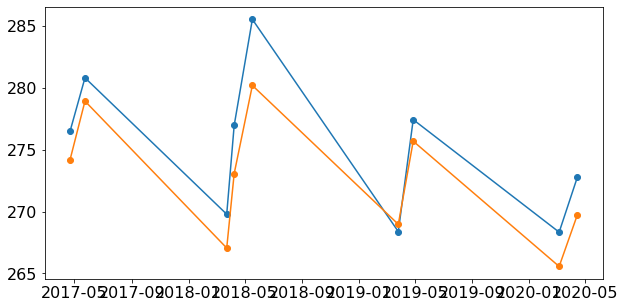

In [11]:
gt_k = []
lt_k = []
medians = []
times = []

for i in range(0,len(ds.time)):
    if ds.time.isel(time=i).dt.hour > 12:
        # find the 50% quantile (median) (or some other quantile) and use that as the threshold
        xx = ds.fveg.isel(time=i).values.ravel()
        xx = xx[~np.isnan(xx)]
        q50 = np.quantile(xx, 0.50) # median
        k = q50
        times.append(ds.time.isel(time=i).values)
        medians.append(k)
        gt_k.append(ds.ast_goes_aster_rad2tbK.where(ds.fveg >= k).isel(time=i).mean().values)
        lt_k.append(ds.ast_goes_aster_rad2tbK.where(ds.fveg < k).isel(time=i).mean().values)

plt.figure(figsize=(10,5))
plt.plot(times, gt_k, 'o-')
plt.plot(times, lt_k,'o-')
#plt.plot(times,np.array(gt_k)-np.array(lt_k),'o-')

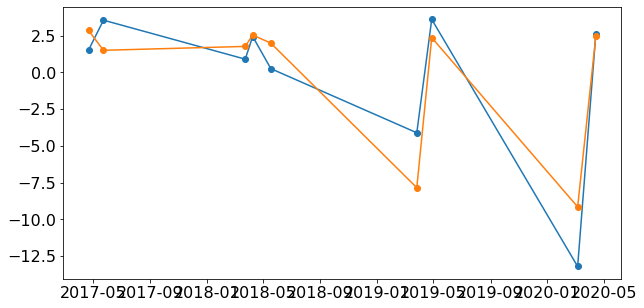

In [12]:
gt_k = []
lt_k = []
medians = []
times = []

for i in range(0,len(ds.time)):
    if ds.time.isel(time=i).dt.hour > 12:
        # find the 50% quantile (median) (or some other quantile) and use that as the threshold
        xx = ds.fveg.isel(time=i).values.ravel()
        xx = xx[~np.isnan(xx)]
        q50 = np.quantile(xx, 0.50) # median
        k = q50
        times.append(ds.time.isel(time=i).values)
        medians.append(k)
        gt_k.append(ds.ast_goes_mean_diff_tb.where(ds.fveg >= k).isel(time=i).mean().values)
        lt_k.append(ds.ast_goes_mean_diff_tb.where(ds.fveg < k).isel(time=i).mean().values)

plt.figure(figsize=(10,5))
plt.plot(times, gt_k, 'o-')
plt.plot(times, lt_k, 'o-')
#plt.ylim(-3.5,3.5)
#plt.plot(times,np.array(gt_k)-np.array(lt_k),'o-')

### Make three zonal categories, 

1) terrain facing GOES-16 ABI, (hillshade values > 0.5)

2) terrain facing away from GOES-16 ABI, (0.0 < hillshade values < 0.5)

3) occluded terrain not visible to GOES-16 ABI. (hillshade Values < 0.0)

**For daytime only**

In [13]:
#fig, [ax1, ax2, ax3] = plt.subplots(nrows=1,ncols=3,figsize=(15,5))
#ds.dem.plot.hist(bins=100, ax=ax1);
#ds.dem_slope.plot.hist(bins=100, ax=ax2);
#ds.dem_aspect.plot.hist(bins=100, ax=ax3);
#


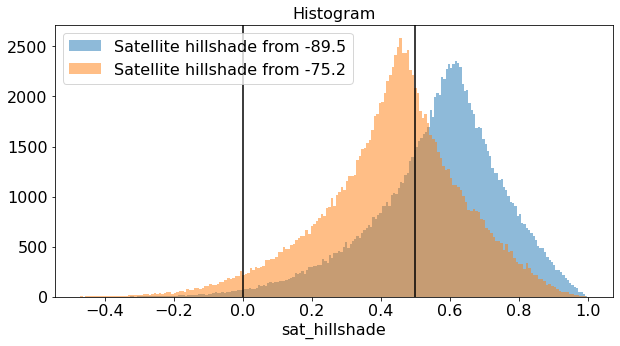

In [14]:
plt.figure(figsize=(10,5))
ds.sat_hillshade.isel(time=0).plot.hist(bins=200,alpha=0.5, label='Satellite hillshade from -89.5');
ds.sat_hillshade.isel(time=20).plot.hist(bins=200,alpha=0.5, label='Satellite hillshade from -75.2');
plt.axvline(0,c='k')
plt.axvline(0.5,c='k')
plt.legend()

50167 607245 16769


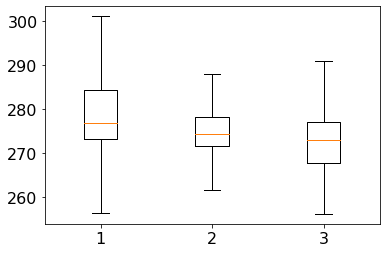

In [15]:
# Group A: terrain facing GOES-16 ABI, (hillshade values => 0.5)
group_a = ds.where(ds.time.dt.hour > 12).where(ds.sat_hillshade >= 0.75).ast_goes_aster_rad2tbK.values.ravel()
group_a = group_a[~np.isnan(group_a)]
# Group B: terrain facing away from GOES-16 ABI, (0.0 <= hillshade values < 0.5)
group_b = ds.where(ds.time.dt.hour > 12).where(ds.sat_hillshade < 0.75).where(ds.sat_hillshade >= 0.0).ast_goes_aster_rad2tbK.values.ravel()
group_b = group_b[~np.isnan(group_b)]
# Group C: occluded terrain not visible to GOES-16 ABI. (hillshade Values < 0.0)
group_c = ds.where(ds.time.dt.hour > 12).where(ds.sat_hillshade < 0.0).ast_goes_aster_rad2tbK.values.ravel()
group_c = group_c[~np.isnan(group_c)]

print(len(group_a),len(group_b),len(group_c))

plt.boxplot([group_a, 
             group_b, 
             group_c], showfliers=False);

**For daytime, look at **

### Make two zonal categories, 

1) terrain facing the sun (hillshade values > median hillshade)

2) terrain facing away from the sun, (hillshade values < median hillshade)



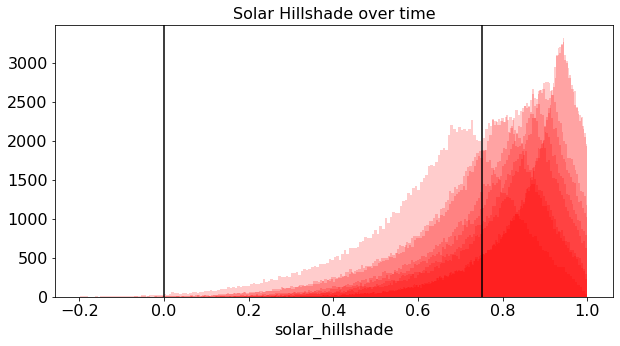

In [16]:
plt.figure(figsize=(10,5))
for i in range(0,len(ds.time)):
    if ds.time.isel(time=i).dt.hour > 12:
        ds.solar_hillshade.isel(time=i).plot.hist(bins=200,color='red',alpha=0.2);
plt.axvline(0,c='k')
plt.axvline(0.75,c='k')        
plt.title('Solar Hillshade over time');

In [17]:
k

0.13142857142857142

171196 502985 16769 1351147


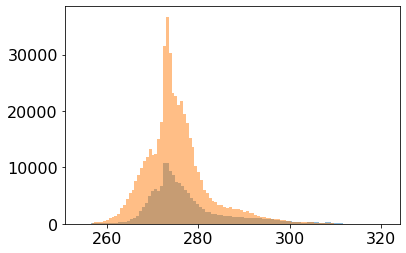

In [18]:
# ASTER Temperatures by group
k = ds.solar_hillshade.quantile(0.75, dim=('x','y'))#ds.solar_hillshade.median(axis=(1,2))

# Group A: terrain facing the Sun, (hillshade values => 0.5)
group_a = ds.where(ds.time.dt.hour > 12).where(ds.solar_hillshade >= k).ast_goes_aster_rad2tbK.values.ravel()
group_a = group_a[~np.isnan(group_a)]
# Group B: terrain facing away from  the Sun, (0.0 <= hillshade values < 0.5)
group_b = ds.where(ds.time.dt.hour > 12).where(ds.solar_hillshade < k).ast_goes_aster_rad2tbK.values.ravel()
group_b = group_b[~np.isnan(group_b)]
## Group C: occluded terrain not visible to the Sun (in shade). (hillshade Values < 0.0)
#group_c = ds.where(ds.time.dt.hour > 12).where(ds.solar_hillshade_goes_zonal_mean < 0.0).ast_goes_aster_rad2tbK.values.ravel()
#group_c = group_c[~np.isnan(group_c)]
# Group D: all nighttime values
group_d = ds.where(ds.time.dt.hour < 12).ast_goes_aster_rad2tbK.values.ravel()
group_d = group_d[~np.isnan(group_d)]


print(len(group_a),len(group_b),len(group_c),len(group_d))

#plt.boxplot([group_a, 
#             group_b, 
#             #group_c,
#             group_d], showfliers=True);

plt.hist(group_a,bins=100,alpha=0.5);
plt.hist(group_b,bins=100,alpha=0.5);
#plt.hist(group_d,bins=100,alpha=0.5);

171196 502985 16769 1351147


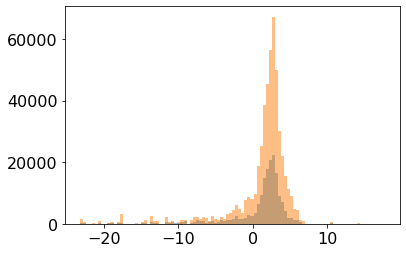

In [19]:
# ABI - ASTER deltaT by group
k = ds.solar_hillshade.quantile(0.75, dim=('x','y'))#ds.solar_hillshade.median(axis=(1,2))

# Group A: terrain facing the Sun, (hillshade values => 0.5)
group_a = ds.where(ds.time.dt.hour > 12).where(ds.solar_hillshade >= k).ast_goes_mean_diff_tb.values.ravel()
group_a = group_a[~np.isnan(group_a)]
# Group B: terrain facing away from  the Sun, (hillshade values < 0.5)
group_b = ds.where(ds.time.dt.hour > 12).where(ds.solar_hillshade < k).ast_goes_mean_diff_tb.values.ravel()
group_b = group_b[~np.isnan(group_b)]
## Group C: occluded terrain not visible to the Sun (in shade). (hillshade Values < 0.0)
#group_c = ds.where(ds.time.dt.hour > 12).where(ds.solar_hillshade_goes_zonal_mean < 0.0).ast_goes_mean_diff_tb.values.ravel()
#group_c = group_c[~np.isnan(group_c)]
# Group D: all nighttime values
group_d = ds.where(ds.time.dt.hour < 12).ast_goes_mean_diff_tb.values.ravel()
group_d = group_d[~np.isnan(group_d)]


print(len(group_a),len(group_b),len(group_c),len(group_d))

#plt.boxplot([group_a, 
#             group_b, 
#             #group_c,
#             group_d], showfliers=True);
#
plt.hist(group_a,bins=100,alpha=0.5);
plt.hist(group_b,bins=100,alpha=0.5);
#plt.hist(group_d,bins=100,alpha=0.5);

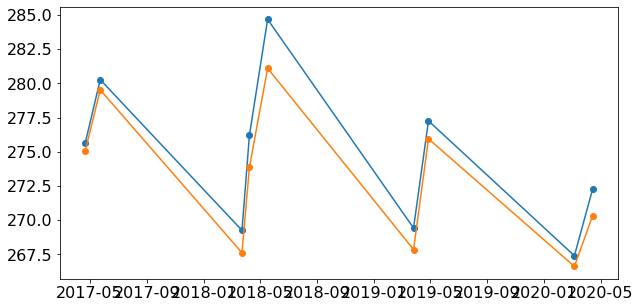

In [20]:
gt_k = []
lt_k = []
medians = []
times = []

for i in range(0,len(ds.time)):
    if ds.time.isel(time=i).dt.hour > 12:
        # find the 50% quantile (median) (or some other quantile) and use that as the threshold
        xx = ds.solar_hillshade.isel(time=i).values.ravel()
        xx = xx[~np.isnan(xx)]
        q50 = np.quantile(xx, 0.50) # median
        k = q50
        times.append(ds.time.isel(time=i).values)
        medians.append(k)
        gt_k.append(ds.ast_goes_aster_rad2tbK.where(ds.solar_hillshade >= k).isel(time=i).mean().values)
        lt_k.append(ds.ast_goes_aster_rad2tbK.where(ds.solar_hillshade < k).isel(time=i).mean().values)

plt.figure(figsize=(10,5))
plt.plot(times, gt_k, 'o-')
plt.plot(times, lt_k,'o-')
#plt.plot(times,np.array(gt_k)-np.array(lt_k),'o-')

############################################################
#
#gt_k = []
#lt_k = []
#medians = []
#
#for i in range(0,len(ds.time)):
#    if ds.time.isel(time=i).dt.hour > 12:
#        # find the 50% quantile (median) (or some other quantile) and use that as the threshold
#        xx = ds.solar_hillshade.isel(time=i).values.ravel()
#        xx = xx[~np.isnan(xx)]
#        q50 = np.quantile(xx, 0.50) # median
#        k = q50
#        medians.append(k)
#        gt_k.append(ds.ast_goes_aster_rad2tbK.where(ds.solar_hillshade_goes_zonal_mean >= k).isel(time=n).mean().values)
#        lt_k.append(ds.ast_goes_aster_rad2tbK.where(ds.solar_hillshade_goes_zonal_mean < k).isel(time=n).mean().values)
#
#plt.figure(figsize=(10,5))
#plt.plot(gt_k)
#plt.plot(lt_k)

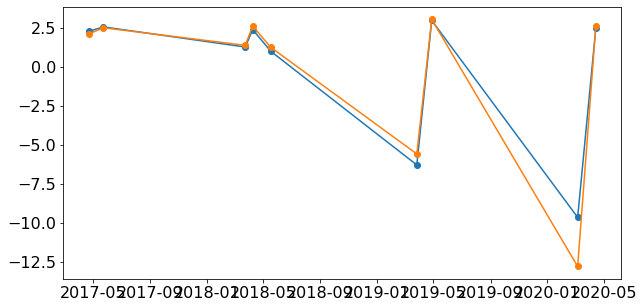

In [21]:
gt_k = []
lt_k = []
medians = []
times = []

for i in range(0,len(ds.time)):
    if ds.time.isel(time=i).dt.hour > 12:
        # find the 50% quantile (median) (or some other quantile) and use that as the threshold
        xx = ds.solar_hillshade.isel(time=i).values.ravel()
        xx = xx[~np.isnan(xx)]
        q50 = np.quantile(xx, 0.50) # median
        k = q50
        times.append(ds.time.isel(time=i).values)
        medians.append(k)
        gt_k.append(ds.ast_goes_mean_diff_tb.where(ds.solar_hillshade >= k).isel(time=i).mean().values)
        lt_k.append(ds.ast_goes_mean_diff_tb.where(ds.solar_hillshade < k).isel(time=i).mean().values)

plt.figure(figsize=(10,5))
plt.plot(times, gt_k, 'o-')
plt.plot(times, lt_k, 'o-')
#plt.ylim(-3.5,3.5)
#plt.plot(times,np.array(gt_k)-np.array(lt_k),'o-')


############################################################
#
#
#gt_k = []
#lt_k = []
#medians = []
#
#for i in range(0,len(ds.time)):
#    if ds.time.isel(time=i).dt.hour > 12:
#        # find the 50% quantile (median) (or some other quantile) and use that as the threshold
#        xx = ds.solar_hillshade.isel(time=i).values.ravel()
#        xx = xx[~np.isnan(xx)]
#        q50 = np.quantile(xx, 0.50) # median
#        k = q50
#        medians.append(k)
#        gt_k.append(ds.ast_goes_mean_diff_tb.where(ds.solar_hillshade_goes_zonal_mean >= k).isel(time=n).mean().values)
#        lt_k.append(ds.ast_goes_mean_diff_tb.where(ds.solar_hillshade_goes_zonal_mean < k).isel(time=n).mean().values)
#
#plt.figure(figsize=(10,5))
#plt.plot(gt_k)
#plt.plot(lt_k)

0.8358289208945802
272.2666284160579
270.32340913901504
2.492405404042898
2.6093250063253586


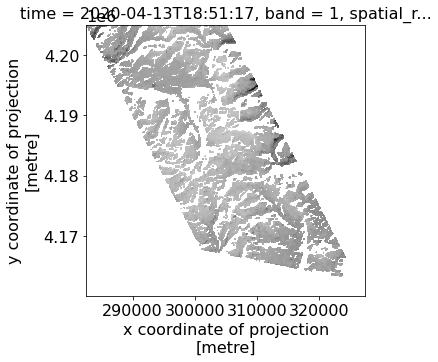

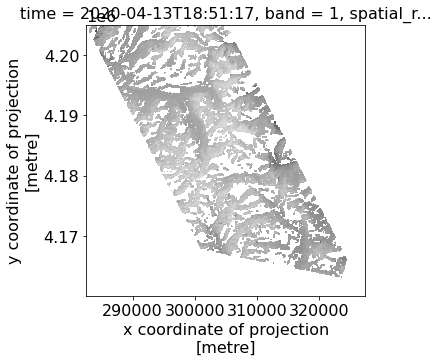

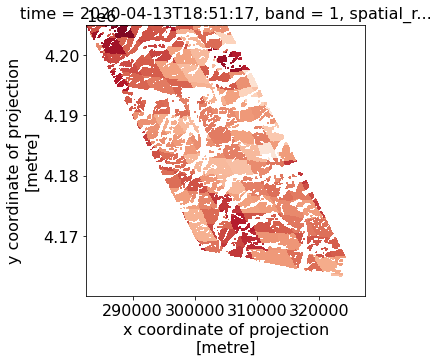

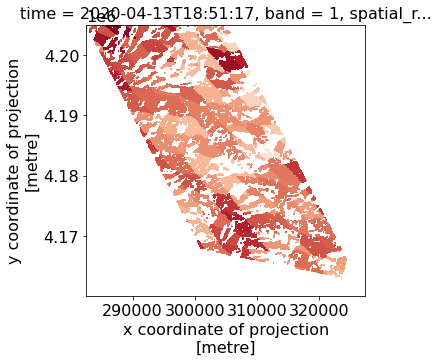

In [22]:
n=26
# find the 50% quantile (median) (or some other quantile) and use that as the threshold
xx = ds.solar_hillshade.isel(time=n).values.ravel()
xx = xx[~np.isnan(xx)]
q50 = np.quantile(xx, 0.50) # median
k = q50
print(k)

plt.figure(figsize=(5,5))
ds.ast_goes_aster_rad2tbK.where(ds.solar_hillshade >= k).isel(time=n).plot(cmap='Greys',vmin=250,vmax=300,add_colorbar=False)
print(ds.ast_goes_aster_rad2tbK.where(ds.solar_hillshade >= k).isel(time=n).mean().values)
plt.figure(figsize=(5,5))
ds.ast_goes_aster_rad2tbK.where(ds.solar_hillshade < k).isel(time=n).plot(cmap='Greys',vmin=250,vmax=300,add_colorbar=False)
print(ds.ast_goes_aster_rad2tbK.where(ds.solar_hillshade < k).isel(time=n).mean().values)


plt.figure(figsize=(5,5))
ds.ast_goes_mean_diff_tb.where(ds.solar_hillshade >= k).isel(time=n).plot(cmap='RdBu_r',vmin=-5,vmax=5,add_colorbar=False)
print(ds.ast_goes_mean_diff_tb.where(ds.solar_hillshade >= k).isel(time=n).mean().values)
plt.figure(figsize=(5,5))
ds.ast_goes_mean_diff_tb.where(ds.solar_hillshade < k).isel(time=n).plot(cmap='RdBu_r',vmin=-5,vmax=5,add_colorbar=False)
print(ds.ast_goes_mean_diff_tb.where(ds.solar_hillshade < k).isel(time=n).mean().values)

0.79400733401082
271.9773697795157
270.38622242805167
2.3995548630720895
2.7481980271081747


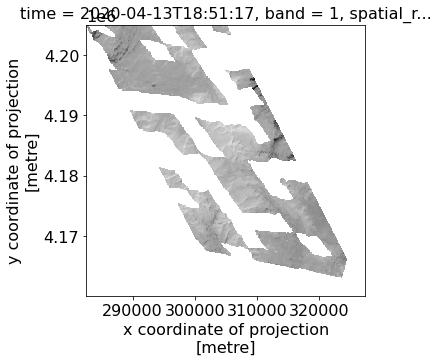

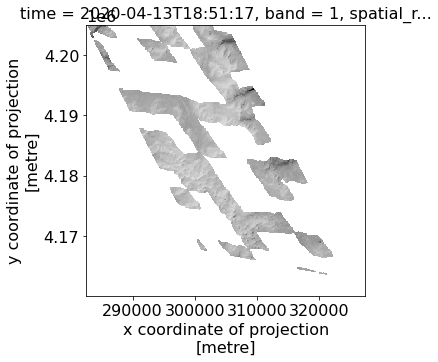

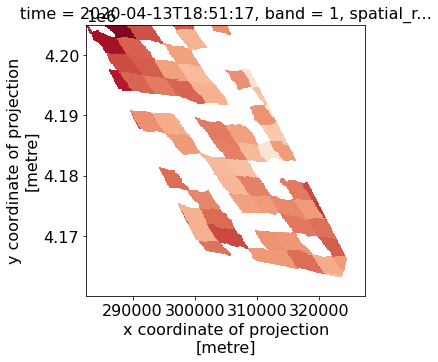

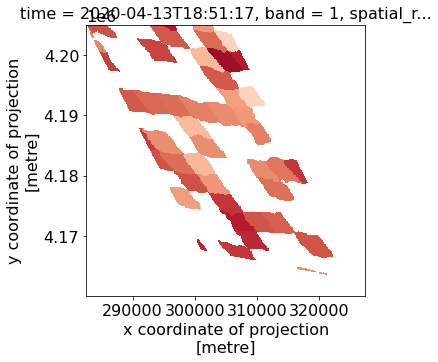

In [23]:
n=26
# find the 50% quantile (median) (or some other quantile) and use that as the threshold
xx = ds.solar_hillshade_goes_zonal_mean.isel(time=n).values.ravel()
xx = xx[~np.isnan(xx)]
q50 = np.quantile(xx, 0.50) # median
k = q50
print(k)

plt.figure(figsize=(5,5))
ds.ast_goes_aster_rad2tbK.where(ds.solar_hillshade_goes_zonal_mean >= k).isel(time=n).plot(cmap='Greys',vmin=250,vmax=300,add_colorbar=False)
print(ds.ast_goes_aster_rad2tbK.where(ds.solar_hillshade_goes_zonal_mean >= k).isel(time=n).mean().values)
plt.figure(figsize=(5,5))
ds.ast_goes_aster_rad2tbK.where(ds.solar_hillshade_goes_zonal_mean < k).isel(time=n).plot(cmap='Greys',vmin=250,vmax=300,add_colorbar=False)
print(ds.ast_goes_aster_rad2tbK.where(ds.solar_hillshade_goes_zonal_mean < k).isel(time=n).mean().values)


plt.figure(figsize=(5,5))
ds.ast_goes_mean_diff_tb.where(ds.solar_hillshade_goes_zonal_mean >= k).isel(time=n).plot(cmap='RdBu_r',vmin=-5,vmax=5,add_colorbar=False)
print(ds.ast_goes_mean_diff_tb.where(ds.solar_hillshade_goes_zonal_mean >= k).isel(time=n).mean().values)
plt.figure(figsize=(5,5))
ds.ast_goes_mean_diff_tb.where(ds.solar_hillshade_goes_zonal_mean < k).isel(time=n).plot(cmap='RdBu_r',vmin=-5,vmax=5,add_colorbar=False)
print(ds.ast_goes_mean_diff_tb.where(ds.solar_hillshade_goes_zonal_mean < k).isel(time=n).mean().values)

647867 26301 13 1351147


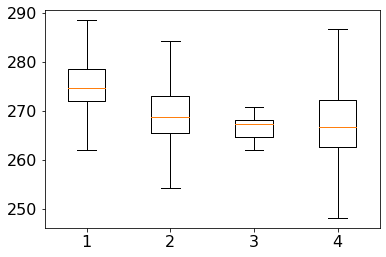

In [24]:
# Group A: terrain facing the Sun, (hillshade values => 0.5)
group_a = ds.where(ds.time.dt.hour > 12).where(ds.solar_hillshade >= 0.5).ast_goes_aster_rad2tbK.values.ravel()
group_a = group_a[~np.isnan(group_a)]
# Group B: terrain facing away from  the Sun, (0.0 <= hillshade values < 0.5)
group_b = ds.where(ds.time.dt.hour > 12).where(ds.solar_hillshade < 0.5).where(ds.solar_hillshade >= 0.0).ast_goes_aster_rad2tbK.values.ravel()
group_b = group_b[~np.isnan(group_b)]
# Group C: occluded terrain not visible to the Sun (in shade). (hillshade Values < 0.0)
group_c = ds.where(ds.time.dt.hour > 12).where(ds.solar_hillshade < 0.0).ast_goes_aster_rad2tbK.values.ravel()
group_c = group_c[~np.isnan(group_c)]
# Group D: all nighttime values
group_d = ds.where(ds.time.dt.hour < 12).ast_goes_aster_rad2tbK.values.ravel()
group_d = group_d[~np.isnan(group_d)]


print(len(group_a),len(group_b),len(group_c),len(group_d))

plt.boxplot([group_a, 
             group_b, 
             group_c,
             group_d], showfliers=False);

---
---
---

what if I weighted ASTER by GOES satellite view hillslope?

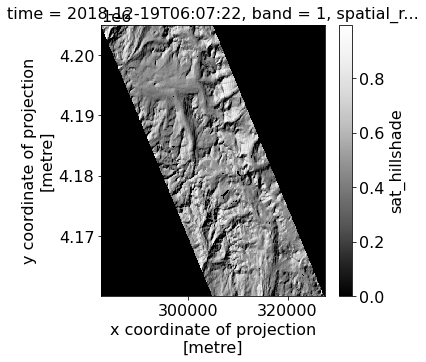

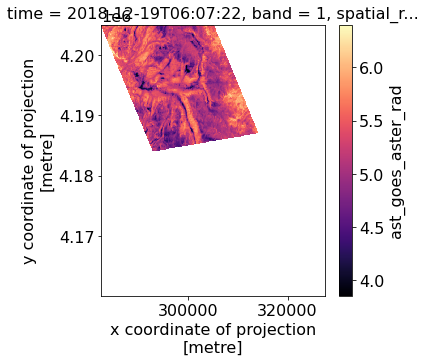

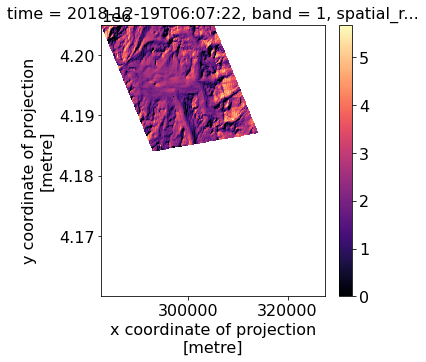

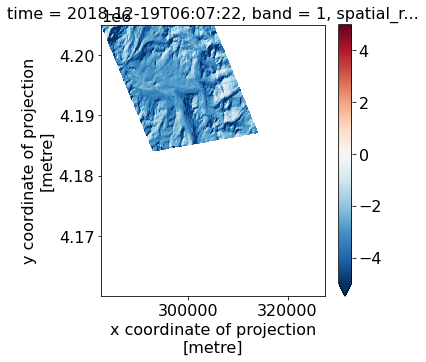

In [25]:
t = 10
ds.where(ds.sat_hillshade>=0, 0).isel(time=t).sat_hillshade.plot(cmap='Greys_r',figsize=(5,5))
ds.isel(time=t).ast_goes_aster_rad.plot(cmap='magma',figsize=(5,5))

weighted = ds.ast_goes_aster_rad * ds.sat_hillshade.where(ds.sat_hillshade>=0, 0)#.where(ds.sat_hillshade<=0,1)
weighted.isel(time=t).plot(cmap='magma',figsize=(5,5))

(weighted - ds.ast_goes_aster_rad).isel(time=t).plot(cmap='RdBu_r',vmin=-5, vmax=5,figsize=(5,5))

---

set up quick plot function

In [26]:
def quick_plot(x,y,x_label,y_label, conf, add_linear_regression=True):
    plt.figure(figsize=(4,4))
    plt.scatter(x,y,marker='.',c='k',alpha=0.2,s=1)
    _x = x[~np.isnan(x)]
    _y = y[~np.isnan(x)]
    slope, intercept, r, p, se = stats.linregress(_x, _y)
    print(slope, intercept, r, p, se)
    if add_linear_regression == True:
        plt.plot(np.linspace(_x.min(),_x.max()),
                 slope*np.linspace(_x.min(),_x.max())+intercept,
                 '--r',zorder=99)
        plot_regression_confidence_intervals(_x,_y,conf)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(f'{x_label}\nversus {y_label}')
    return None

---
---

### Elevation

deltaT versus Elevation for all 27 observations

30.14390811076135 3001.9925760846295 0.26437962399079096 0.0 0.07723860592909075
11.764543765141504 2986.470919658157 0.0902190884555216 0.0 0.09122191533684033


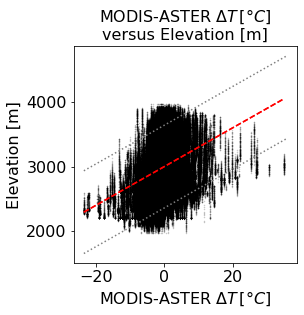

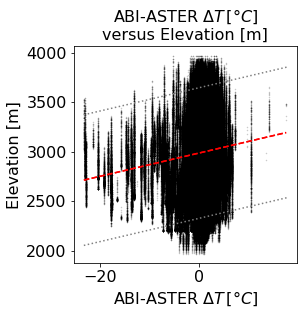

In [27]:
conf = 0.975


y = np.array([ds.dem.values] * 27).ravel()

# MODIS-ASTER deltaT
x = ds.ast_mod_mean_diff_tb.values.ravel()
quick_plot(x,y,'MODIS-ASTER $\Delta T\,[\degree C]$','Elevation [m]', conf)

# ABI-ASTER deltaT
x = ds.ast_goes_mean_diff_tb.values.ravel()
quick_plot(x,y,'ABI-ASTER $\Delta T\,[\degree C]$','Elevation [m]', conf)

## Absolute value of ABI-ASTER deltaT
#x = np.abs(ds.ast_goes_mean_diff_tb.values.ravel())
#quick_plot(x,y,'|ABI-ASTER $\Delta T$| $[\degree C]$','Elevation [m]', conf)



mean deltaT versus Elevation

94.25387159477512 2998.9547112657583 0.4664402229147249 0.0 0.5055631317757869
114.94960283649156 2885.9949835839498 0.28786172896464846 0.0 1.0816550820624027


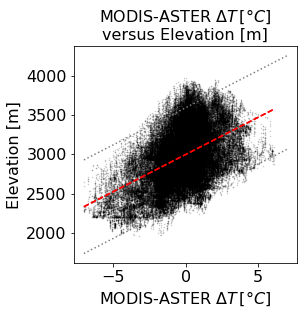

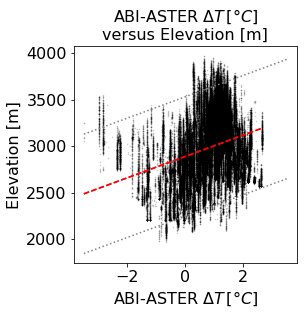

In [28]:
conf = 0.975

y = ds.dem.values.ravel()


# MODIS-ASTER deltaT
x = ds.ast_mod_mean_diff_tb.mean(axis=0).values.ravel()
quick_plot(x,y,'MODIS-ASTER $\Delta T\,[\degree C]$','Elevation [m]', conf)

# ABI-ASTER deltaT
x = ds.ast_goes_mean_diff_tb.mean(axis=0).values.ravel()
quick_plot(x,y,'ABI-ASTER $\Delta T\,[\degree C]$','Elevation [m]', conf)

## Absolute value of ABI-ASTER deltaT
#x = np.abs(ds.ast_goes_mean_diff_tb.mean(axis=0).values.ravel())
#quick_plot(x,y,'|ABI-ASTER $\Delta T$| $[\degree C]$','Elevation [m]', conf)

## Slope

-0.1435889250197692 16.87504425569745 -0.04069497472008953 0.0 0.0024763810971603784
-0.16913407938068103 17.047048832221353 -0.04191272370840509 0.0 0.002832048438566293


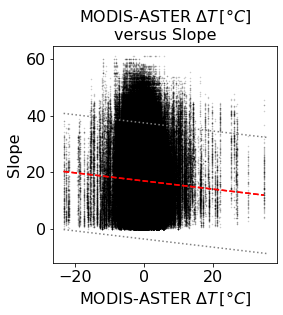

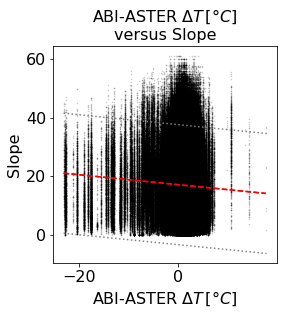

In [29]:
conf = 0.975

y = np.array([ds.dem_slope.values] * 27).ravel()

# MODIS-ASTER deltaT
x = ds.ast_mod_mean_diff_tb.values.ravel()
quick_plot(x,y,'MODIS-ASTER $\Delta T\,[\degree C]$','Slope', conf)

# ABI-ASTER deltaT
x = ds.ast_goes_mean_diff_tb.values.ravel()
quick_plot(x,y,'ABI-ASTER $\Delta T\,[\degree C]$','Slope', conf)

## Absolute value of ABI-ASTER deltaT
#x = np.abs(ds.ast_goes_mean_diff_tb.values.ravel())
#quick_plot(x,y,'|ABI-ASTER $\Delta T$| $[\degree C]$','Slope', conf)

-0.4091638920206415 16.738373294620907 -0.06661372405501065 6.564886821174191e-123 0.01733470057499062
-1.4035267830590885 17.97639970209538 -0.11562900163257687 0.0 0.03410197568459317


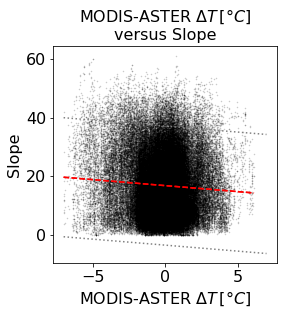

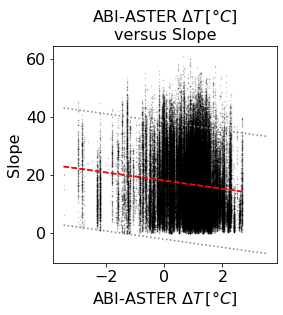

In [30]:
conf = 0.975

y = ds.dem_slope.values.ravel()

# MODIS-ASTER deltaT
x = ds.ast_mod_mean_diff_tb.mean(axis=0).values.ravel()
quick_plot(x,y,'MODIS-ASTER $\Delta T\,[\degree C]$','Slope', conf)

# ABI-ASTER deltaT
x = ds.ast_goes_mean_diff_tb.mean(axis=0).values.ravel()
quick_plot(x,y,'ABI-ASTER $\Delta T\,[\degree C]$','Slope', conf)

## Absolute value of ABI-ASTER deltaT
#x = np.abs(ds.ast_goes_mean_diff_tb.mean(axis=0).values.ravel())
#quick_plot(x,y,'|ABI-ASTER $\Delta T$| $[\degree C]$','Slope', conf)
#


### sat hillshade

nan nan nan nan nan
nan nan nan nan nan


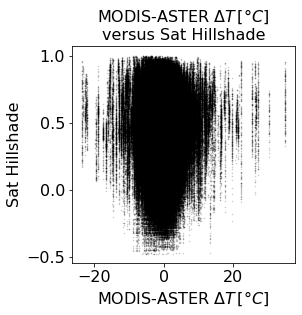

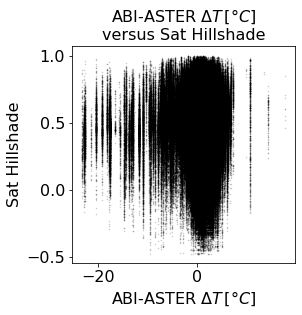

In [31]:
conf = 0.975

y = ds.sat_hillshade.values.ravel()

# MODIS-ASTER deltaT
x = ds.ast_mod_mean_diff_tb.values.ravel()
quick_plot(x,y,'MODIS-ASTER $\Delta T\,[\degree C]$','Sat Hillshade', conf)

# ABI-ASTER deltaT
x = ds.ast_goes_mean_diff_tb.values.ravel()
quick_plot(x,y,'ABI-ASTER $\Delta T\,[\degree C]$','Sat Hillshade', conf)

## Absolute value of ABI-ASTER deltaT
#x = np.abs(ds.ast_goes_mean_diff_tb.values.ravel())
#quick_plot(x,y,'|ABI-ASTER $\Delta T$| $[\degree C]$','Sat Hillshade', conf)

-0.0008736646633860809 0.45950160756805086 -0.03418855056276316 0.0 1.7939376697749337e-05
0.0011746984151513589 0.4586371822545716 0.040193629349781275 0.0 2.0512344373475895e-05


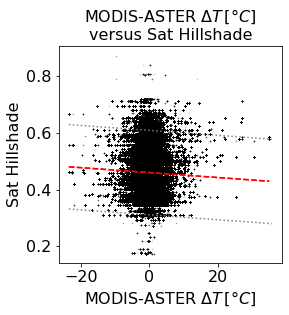

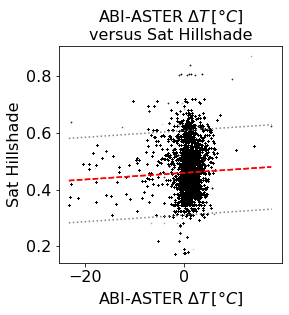

In [32]:
conf = 0.975

y = ds.sat_hillshade_goes_zonal_mean.values.ravel()

# MODIS-ASTER deltaT
x = ds.ast_mod_mean_diff_tb.values.ravel()
quick_plot(x,y,'MODIS-ASTER $\Delta T\,[\degree C]$','Sat Hillshade', conf)
#plt.xlim(-2,2)

# ABI-ASTER deltaT
x = ds.ast_goes_mean_diff_tb.values.ravel()
quick_plot(x,y,'ABI-ASTER $\Delta T\,[\degree C]$','Sat Hillshade', conf)
#plt.xlim(-2,2)

## Absolute value of ABI-ASTER deltaT
#x = np.abs(ds.ast_goes_mean_diff_tb.values.ravel())
#quick_plot(x,y,'|ABI-ASTER $\Delta T$| $[\degree C]$','Sat Hillshade', conf)

---

### solar hillshade
(daytime only)

nan nan nan nan nan
nan nan nan nan nan


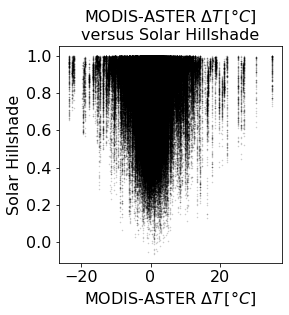

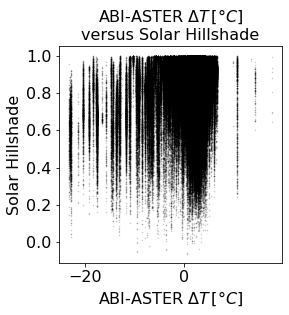

In [33]:
conf = 0.975

y = ds.where(ds.time.dt.hour == 18).solar_hillshade.values.ravel()

# MODIS-ASTER deltaT
x = ds.where(ds.time.dt.hour == 18).ast_mod_mean_diff_tb.values.ravel()
quick_plot(x,y,'MODIS-ASTER $\Delta T\,[\degree C]$','Solar Hillshade', conf)
#plt.xlim(-10,10)

# ABI-ASTER deltaT
x = ds.where(ds.time.dt.hour == 18).ast_goes_mean_diff_tb.values.ravel()
quick_plot(x,y,'ABI-ASTER $\Delta T\,[\degree C]$','Solar Hillshade', conf)
#plt.xlim(-10,10)

## Absolute value of ABI-ASTER deltaT
#x = np.abs(ds.where(ds.time.dt.hour == 18).ast_goes_mean_diff_tb.values.ravel())
#quick_plot(x,y,'|ABI-ASTER $\Delta T$| $[\degree C]$','Solar Hillshade', conf)

In [34]:
#for i in range(0,len(ds.time)):
#    plt.figure()
#    ds.isel(time=i).solar_hillshade.plot(cmap='Greys_r',vmin=0,vmax=1)
#    plt.savefig(f'tmp{i}.jpg')
#    plt.close()
#    
#!convert -delay 10 tmp*.jpg solar_hillshade_animation.gif

In [35]:
#for i in range(0,len(ds.time)):
#    plt.figure(figsize=(3,3))
#    plt.title(ds.isel(time=i).time.values)
#    plt.plot(ds.isel(time=i).ast_goes_mean_diff_tb.values.ravel(),
#             ds.isel(time=i).solar_hillshade_goes_zonal_mean.values.ravel(),
#             linestyle='none', marker='.', c='k')
#    plt.ylim(0,1)
#    plt.xlim(-20,20)

0.0011371940199258804 0.8190092620841105 0.06594757578989503 0.0 2.0933192191833795e-05
0.007305771125793128 0.8106293944758406 0.43938780800645416 0.0 1.817123394478498e-05


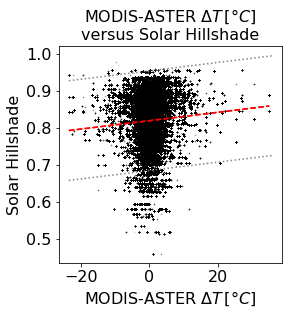

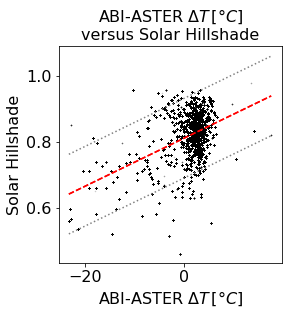

In [36]:
conf = 0.975

y = ds.where(ds.time.dt.hour == 18).solar_hillshade_goes_zonal_mean.values.ravel()

# MODIS-ASTER deltaT
x = ds.where(ds.time.dt.hour == 18).ast_mod_mean_diff_tb.values.ravel()
quick_plot(x,y,'MODIS-ASTER $\Delta T\,[\degree C]$','Solar Hillshade', conf)
#plt.xlim(-10,10)

# ABI-ASTER deltaT
x = ds.where(ds.time.dt.hour == 18).ast_goes_mean_diff_tb.values.ravel()
quick_plot(x,y,'ABI-ASTER $\Delta T\,[\degree C]$','Solar Hillshade', conf)
#plt.xlim(-10,10)

## Absolute value of ABI-ASTER deltaT
#x = np.abs(ds.where(ds.time.dt.hour == 18).ast_goes_mean_diff_tb.values.ravel())
#quick_plot(x,y,'|ABI-ASTER $\Delta T$| $[\degree C]$','Solar Hillshade', conf)

### DAH

daytime only

nan nan nan nan nan
nan nan nan nan nan


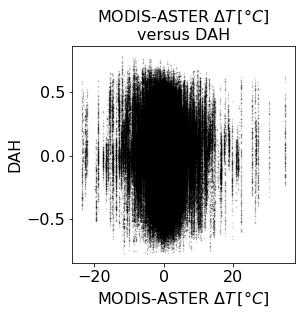

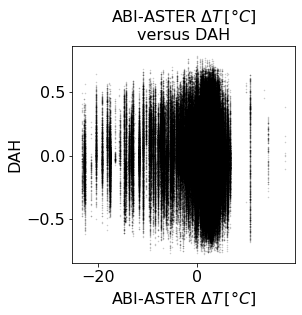

In [37]:
conf = 0.975

y = ds.DAH.values.ravel()

# MODIS-ASTER deltaT
x = ds.where(ds.time.dt.hour == 18).ast_mod_mean_diff_tb.values.ravel()
quick_plot(x,y,'MODIS-ASTER $\Delta T\,[\degree C]$','DAH', conf)
#plt.xlim(-10,10)

# ABI-ASTER deltaT
x = ds.where(ds.time.dt.hour == 18).ast_goes_mean_diff_tb.values.ravel()
quick_plot(x,y,'ABI-ASTER $\Delta T\,[\degree C]$','DAH', conf)
#plt.xlim(-10,10)

## Absolute value of ABI-ASTER deltaT
#x = np.abs(ds.where(ds.time.dt.hour == 18).ast_goes_mean_diff_tb.values.ravel())
#quick_plot(x,y,'|ABI-ASTER $\Delta T$| $[\degree C]$','DAH', conf)

0.0027738240048717586 0.0101262003325436 0.17576128870476515 0.0 1.8901137290236387e-05
-0.0012185678069746222 0.011845356194879359 -0.08007771967234159 0.0 1.8453861444493312e-05


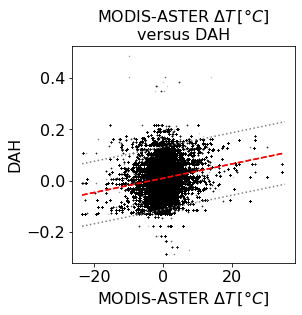

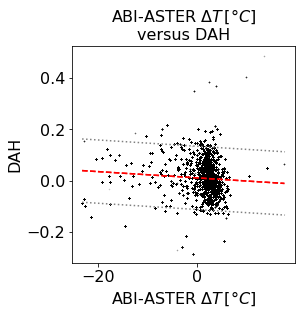

In [38]:
conf = 0.975

y = ds.where(ds.time.dt.hour == 18).DAH_goes_zonal_mean.values.ravel()

# MODIS-ASTER deltaT
x = ds.where(ds.time.dt.hour == 18).ast_mod_mean_diff_tb.values.ravel()
quick_plot(x,y,'MODIS-ASTER $\Delta T\,[\degree C]$','DAH', conf)
#plt.xlim(-10,10)

# ABI-ASTER deltaT
x = ds.where(ds.time.dt.hour == 18).ast_goes_mean_diff_tb.values.ravel()
quick_plot(x,y,'ABI-ASTER $\Delta T\,[\degree C]$','DAH', conf)
#plt.xlim(-10,10)
#plt.ylim(-.5,.5)

## Absolute value of ABI-ASTER deltaT
#x = np.abs(ds.where(ds.time.dt.hour == 18).ast_goes_mean_diff_tb.values.ravel())
#quick_plot(x,y,'|ABI-ASTER $\Delta T$| $[\degree C]$','DAH', conf)

### Aspect

(0.0, 6.283185307179586, 0.0, 1.0550000000000004)

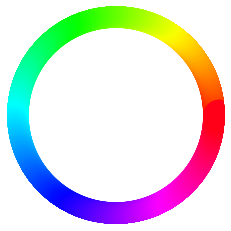

In [39]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

xval = np.arange(0, 2*np.pi, 0.01)
yval = np.ones_like(xval)

colormap = plt.get_cmap('hsv')
norm = mpl.colors.Normalize(0.0, 2*np.pi)

ax = plt.subplot(1,1,1, polar=True)
ax.scatter(xval, yval, c=xval, s=1000, cmap=colormap, norm=norm, linewidths=0)
#ax.set_yticks([])
ax.axis('off')

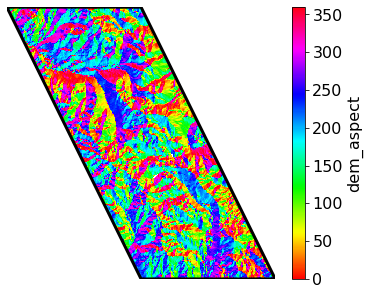

In [40]:
fig, ax = plt.subplots(figsize=(6,5))
ds.dem_aspect.plot(ax=ax, cmap='hsv')
ax.axis('off')
ax.set_title('')
ax.plot([utm_e_UL, utm_e_UR, utm_e_LR, utm_e_LL, utm_e_UL],
                 [utm_n_UL, utm_n_UR, utm_n_LR, utm_n_LL, utm_n_UL],
                 linestyle='-', color='k', lw=3)

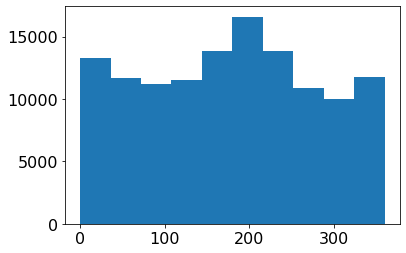

In [41]:
plt.hist(ds.dem_aspect.values.ravel());

In [42]:
ds_day = ds.where(ds.time.dt.hour==18)
ds_night = ds.where(ds.time.dt.hour==6)

In [43]:
def pol2cart(rho, phi, rotate):
    # given a point's polar coordinates rho (radial distance), phi (clockwise azimuth angle), 
    # and rotate (angle to add to phi to put 0 degrees at the top like a compass)
    #https://stackoverflow.com/questions/20924085/python-conversion-between-coordinates
    x = rho * np.cos(np.radians(-phi+rotate))
    y = rho * np.sin(np.radians(-phi+rotate))
    return(x, y)

In [44]:
ds_day = ds.where(ds.time.dt.hour==18, drop=True)
ds_night = ds.where(ds.time.dt.hour==6, drop=True)

In [45]:
azis_all = np.array([ds.dem_aspect.values]*len(ds.time)).ravel() # azimuth angles these are oriented with 0 as south, 180 as north
azis_day = np.array([ds.dem_aspect.values]*len(ds_day.time)).ravel() # azimuth angles these are oriented with 0 as south, 180 as north
azis_night = np.array([ds.dem_aspect.values]*len(ds_night.time)).ravel() # azimuth angles these are oriented with 0 as south, 180 as north
temps_day = ds_day.ast_goes_mean_diff_tb.values.ravel() # ABI temperatures day
temps_night = ds_night.ast_goes_mean_diff_tb.values.ravel() # ABI temperatures night
#temps_day = ds_day.ast_mod_mean_diff_tb.values.ravel() # MODIS temperatures day
#temps_night = ds_night.ast_mod_mean_diff_tb.values.ravel() # MODIS temperatures night

rotate = 90 # rotate 90 for 0 at top, rotate -90 for 0 at bottom 

# for all data
x_day,y_day = pol2cart(temps_day,azis_day,rotate)
x_night,y_night = pol2cart(temps_night,azis_night,rotate) 

# average by 1 degree bins
azis_day_1deg = np.round(azis_day,0)
azis_night_1deg = np.round(azis_night,0)
azis_all_1deg = np.round(azis_all,0)
temps_day_1deg = []
temps_night_1deg = []
counts_1deg = []
for a in range(0,360):
    temps_day_1deg.append(np.nanmean(temps_day[azis_day_1deg == a]))
    temps_night_1deg.append(np.nanmean(temps_night[azis_night_1deg == a]))
    counts_1deg.append(len(azis_all_1deg[azis_all_1deg == a]))

x_day_1deg,y_day_1deg = pol2cart(temps_day_1deg,np.array(range(0,360)),rotate) 
x_night_1deg,y_night_1deg = pol2cart(temps_night_1deg,np.array(range(0,360)),rotate)
x_counts, y_counts = pol2cart(counts_1deg,np.array(range(0,360)),rotate)

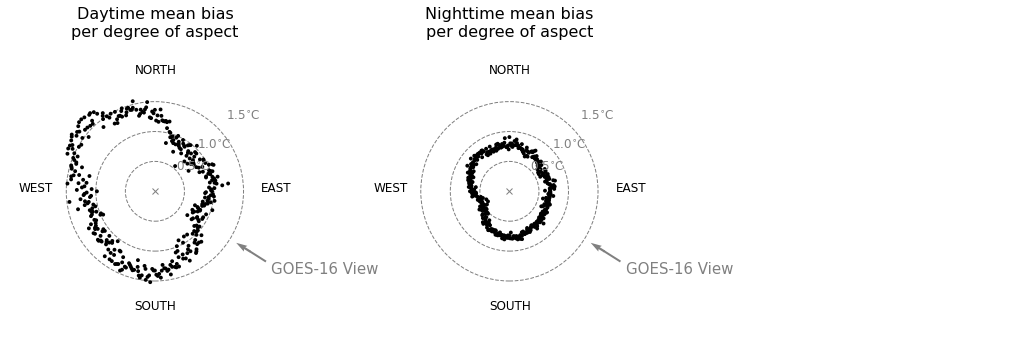

In [46]:





fig, [ax, ax2, ax3] = plt.subplots(1, 3, figsize=(18,5.5))



for each_ax in [ax, ax2]:
    each_ax.plot(0,0,'x',color='grey')
    circle0p5 = plt.Circle((0, 0), radius=0.5, color='grey', fill=False, linestyle='--')
    circle1 = plt.Circle((0, 0), radius=1, color='grey', fill=False, linestyle='--')
    circle1p5 = plt.Circle((0, 0), radius=1.5, color='grey', fill=False, linestyle='--')
    each_ax.add_artist(circle0p5)
    each_ax.add_artist(circle1)
    each_ax.add_artist(circle1p5)


    # SOUTH should be 180
    x_south,y_south = pol2cart(2,190,rotate)
    each_ax.text(x_south,y_south,'SOUTH',fontsize=12)
    
    # EAST should be 90
    x_east,y_east = pol2cart(1.8,90,rotate)
    each_ax.text(x_east,y_east,'EAST',fontsize=12)
    
    # NORTH should be 0
    x_north,y_north = pol2cart(2,350,rotate)
    each_ax.text(x_north,y_north,'NORTH',fontsize=12)
    
    # WEST should be 270
    x_west,y_west = pol2cart(2.3,270,rotate)
    each_ax.text(x_west,y_west ,'WEST',fontsize=12)

    each_ax.text(.35,.35,'0.5$^{\circ}$C',color='grey',fontsize=12)
    each_ax.text(.72,.72,'1.0$^{\circ}$C',color='grey',fontsize=12)
    each_ax.text(1.2,1.2,'1.5$^{\circ}$C',color='grey',fontsize=12)



# DAY
#ax.scatter(x,y,s=5,alpha=0.3,facecolors='tab:gray', edgecolors='none',label='Temperature per 1$^{\circ}$ azimuth bin');
ax.scatter(x_day_1deg,y_day_1deg,s=15,alpha=1,facecolors='k', edgecolors='none',zorder=3,label='Mean Temperature per 1$^{\circ}$ azimuth bin');
#ax.plot(x_1deg,y_1deg,markersize=10,alpha=1, linestyle='-',c='r', zorder=3,label='Mean Temperature per 1$^{\circ}$ azimuth bin');
ax.set_title('Daytime mean bias\nper degree of aspect')

# NIGHT
ax2.scatter(x_night_1deg,y_night_1deg,s=15,alpha=1,facecolors='k', edgecolors='none',zorder=3,label='Mean Temperature per 1$^{\circ}$ azimuth bin');
ax2.set_title('Nighttime')
ax2.set_title('Nighttime mean bias\nper degree of aspect')

# HISTOGRAM (sort of) of AZIMUTHS
#ax3.scatter(x_counts,y_counts,s=15,alpha=1,facecolors='k', edgecolors='none',zorder=3,label='Mean Temperature per 1$^{\circ}$ azimuth bin');
ax3.axis('off')

for each_ax in [ax, ax2]:
    each_ax.set_xlim((-2.5,2.5))
    each_ax.set_ylim((-2.5,2.5))
    each_ax.axis('off')
    # Direction of GOES-16's view is about 122 degrees (when north is 0), but here with south as 0, that is 180+122 = 302
    pointer_loc = 1.9
    length = .3
    sun_x, sun_y = pol2cart(pointer_loc+length,122,rotate)
    sun_x2, sun_y2 = pol2cart(pointer_loc,122,rotate)
    each_ax.quiver(sun_x2,sun_y2,-sun_x2,-sun_y2,color='grey',label='GOES-16 ABI')
    each_ax.plot([sun_x,sun_x2],[sun_y,sun_y2],'-',linewidth='2',color='grey')
    each_ax.text(sun_x+.1, sun_y-.2,'GOES-16 View',fontsize=15,color='grey')

#plt.legend(loc='lower right')
plt.savefig('images/mean_bias_per_degree_aspect_day_night_ASTER-ABI.png',dpi=200)




---

### FSCA

0.014746310369328363 0.633815537182273 0.12765520834040414 0.0 8.442055155868228e-05
0.01410226501154172 0.6182745237324613 0.109053702228722 0.0 9.471562118929091e-05


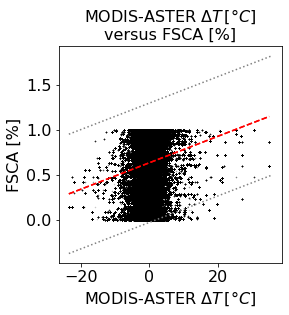

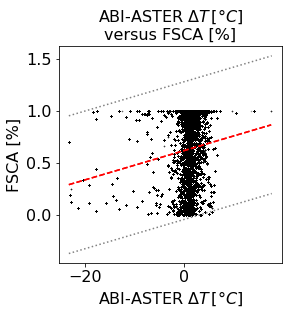

In [47]:
conf = 0.975


_y = ds.fsca.values.ravel()
_y2 = _y[~np.isnan(_y)]
y = _y2[_y2!=0]

# MODIS-ASTER deltaT
_x = ds.ast_mod_mean_diff_tb.values.ravel()
x = _x[~np.isnan(_y)]
x = x[_y2!=0]
quick_plot(x,y,'MODIS-ASTER $\Delta T\,[\degree C]$','FSCA [%]', conf)

# ABI-ASTER deltaT
_x = ds.ast_goes_mean_diff_tb.values.ravel()
x = _x[~np.isnan(_y)]
x = x[_y2!=0]
quick_plot(x,y,'ABI-ASTER $\Delta T\,[\degree C]$','FSCA [%]', conf)

## Absolute value of ABI-ASTER deltaT
#x = np.abs(ds.ast_goes_mean_diff_tb.values.ravel())
#quick_plot(x,y,'|ABI-ASTER $\Delta T$| $[\degree C]$','Elevation [m]', conf)



---
### Fveg, separate day/night

-0.007083913550507848 0.23831862441590587 -0.12767561360891788 0.0 6.694876656507236e-05
-0.003148586226186217 0.24121492398617986 -0.05885291297865551 0.0 6.497411562332327e-05
-0.0049744156680025815 0.23159795806272238 -0.049825091938281656 0.0 8.93337545344192e-05
0.005830051672169567 0.22906795146846004 0.03274199604304533 1.425267867167176e-292 0.00015943942052596078
-0.006195913604481994 0.23383977695836058 -0.08286249978335643 0.0 5.234177374856743e-05
-0.0020384552546327895 0.23670093247535326 -0.023836845532937686 1.707049300705686e-252 6.005182554157045e-05


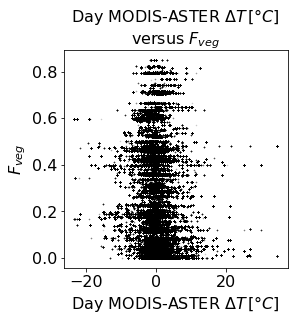

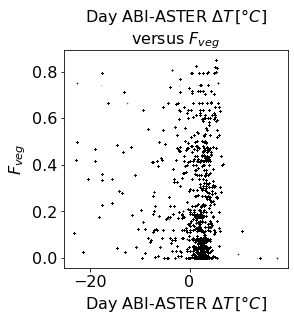

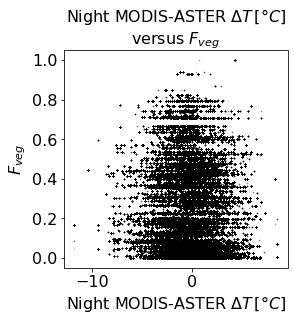

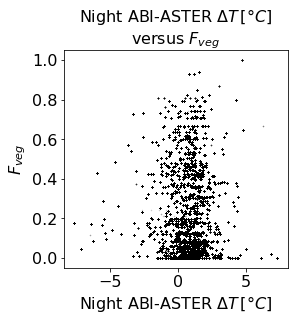

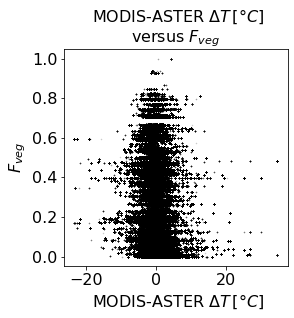

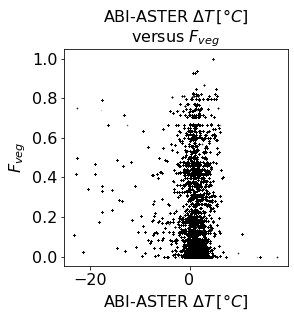

In [48]:
ds_day = ds.where(ds.time.dt.hour==18, drop=True)
ds_night = ds.where(ds.time.dt.hour==6, drop=True)

y = ds_day.fveg.values.ravel()#np.array([ds.fveg.values] * 27).ravel()

# MODIS-ASTER deltaT
x = ds_day.ast_mod_mean_diff_tb.values.ravel()
x0 = x#[y!=0]
y0 = y#[y!=0]
quick_plot(x0,y0,'Day MODIS-ASTER $\Delta T\,[\degree C]$','$F_{veg}$', conf, False)

# ABI-ASTER deltaT
x = ds_day.ast_goes_mean_diff_tb.values.ravel()
x0 = x#[y!=0]
y0 = y#[y!=0]
quick_plot(x0,y0,'Day ABI-ASTER $\Delta T\,[\degree C]$','$F_{veg}$', conf, False)

################################################

y = ds_night.fveg.values.ravel()#np.array([ds.fveg.values] * 27).ravel()
# MODIS-ASTER deltaT
x = ds_night.ast_mod_mean_diff_tb.values.ravel()
x0 = x#[y!=0]
y0 = y#[y!=0]
quick_plot(x0,y0,'Night MODIS-ASTER $\Delta T\,[\degree C]$','$F_{veg}$', conf, False)

# ABI-ASTER deltaT
x = ds_night.ast_goes_mean_diff_tb.values.ravel()
x0 = x#[y!=0]
y0 = y#[y!=0]
quick_plot(x0,y0,'Night ABI-ASTER $\Delta T\,[\degree C]$','$F_{veg}$', conf, False)


## Absolute value of ABI-ASTER deltaT
#x = np.abs(ds_day.ast_goes_mean_diff_tb.values.ravel())
#quick_plot(x,y,'|ABI-ASTER $\Delta T$| $[\degree C]$','$F_{veg}$', conf)


#########################################

y = ds.fveg.values.ravel()#np.array([ds.fveg.values] * 27).ravel()


# MODIS-ASTER deltaT
x = ds.ast_mod_mean_diff_tb.values.ravel()
x0 = x#[y!=0]
y0 = y#[y!=0]
quick_plot(x0,y0,' MODIS-ASTER $\Delta T\,[\degree C]$','$F_{veg}$', conf, False)

# ABI-ASTER deltaT
x = ds.ast_goes_mean_diff_tb.values.ravel()
x0 = x#[y!=0]
y0 = y#[y!=0]
quick_plot(x0,y0,'ABI-ASTER $\Delta T\,[\degree C]$','$F_{veg}$', conf, False)


## Absolute value of ABI-ASTER deltaT
#x = np.abs(ds.ast_goes_mean_diff_tb.values.ravel())
#quick_plot(x,y,'|ABI-ASTER $\Delta T$| $[\degree C]$','$F_{veg}$', conf, False)




-0.007122261378355314 0.24579178724814701 -0.10916897677731902 0.0 0.00018342716732638195
-0.009014362411311464 0.2522773047429797 -0.14159365200562418 0.0 0.00017825508673070668
-0.007532658015449372 0.24057927465788753 -0.05992591552932757 8.432095799266538e-100 0.0003548957810776885
0.03451834200503567 0.21954221353751432 0.09581292604714027 1.109859349789538e-252 0.0010143121984662537
-0.017418342152063684 0.2403343621051918 -0.1351317104810183 0.0 0.00036124024327791466
-0.020594077410513858 0.26067323564392014 -0.08084859114185335 2.7734016417693434e-180 0.0007181155176133712


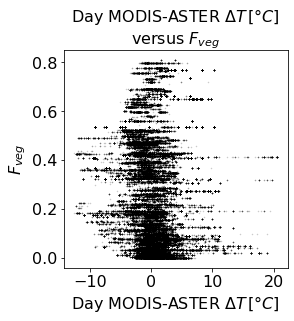

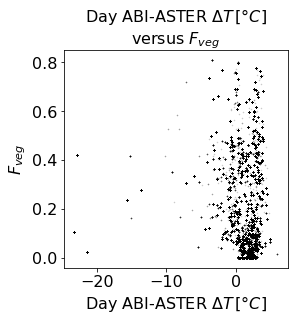

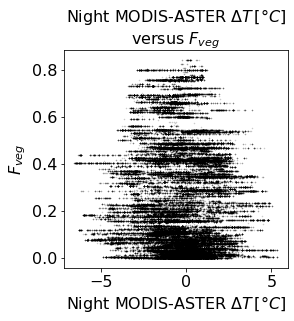

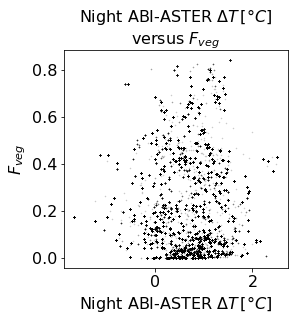

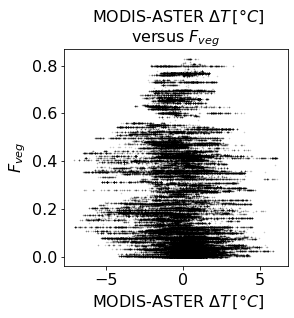

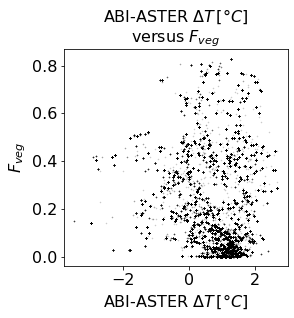

In [49]:


ds_day = ds.where(ds.time.dt.hour==18, drop=True)
ds_night = ds.where(ds.time.dt.hour==6, drop=True)

y = ds_day.fveg.mean(axis=0).values.ravel()


# MODIS-ASTER deltaT
x = ds_day.ast_mod_mean_diff_tb.mean(axis=0).values.ravel()
x0 = x#[y!=0]
y0 = y#[y!=0]
quick_plot(x0,y0,'Day MODIS-ASTER $\Delta T\,[\degree C]$','$F_{veg}$', conf, False)

# ABI-ASTER deltaT
x = ds_day.ast_goes_mean_diff_tb.mean(axis=0).values.ravel()
x0 = x#[y!=0]
y0 = y#[y!=0]
quick_plot(x0,y0,'Day ABI-ASTER $\Delta T\,[\degree C]$','$F_{veg}$', conf, False)

######################################


y = ds_night.fveg.mean(axis=0).values.ravel()


# MODIS-ASTER deltaT
x = ds_night.ast_mod_mean_diff_tb.mean(axis=0).values.ravel()
x0 = x#[y!=0]
y0 = y#[y!=0]
quick_plot(x0,y0,'Night MODIS-ASTER $\Delta T\,[\degree C]$','$F_{veg}$', conf, False)

# ABI-ASTER deltaT
x = ds_night.ast_goes_mean_diff_tb.mean(axis=0).values.ravel()
x0 = x#[y!=0]
y0 = y#[y!=0]
quick_plot(x0,y0,'Night ABI-ASTER $\Delta T\,[\degree C]$','$F_{veg}$', conf, False)




#################


y = ds.fveg.mean(axis=0).values.ravel()


# MODIS-ASTER deltaT
x = ds.ast_mod_mean_diff_tb.mean(axis=0).values.ravel()
x0 = x#[y!=0]
y0 = y#[y!=0]
quick_plot(x0,y0,' MODIS-ASTER $\Delta T\,[\degree C]$','$F_{veg}$', conf, False)

# ABI-ASTER deltaT
x = ds.ast_goes_mean_diff_tb.mean(axis=0).values.ravel()
x0 = x#[y!=0]
y0 = y#[y!=0]
quick_plot(x0,y0,'ABI-ASTER $\Delta T\,[\degree C]$','$F_{veg}$', conf, False)


## Absolute value of ABI-ASTER deltaT
#x = np.abs(ds.ast_goes_mean_diff_tb.mean(axis=0).values.ravel())
#quick_plot(x,y,'|ABI-ASTER $\Delta T$| $[\degree C]$','$F_{veg}$', conf, False)



In [92]:
def quick_plot2(x,y,x_label,y_label, conf, add_linear_regression=True, c='k', m='o', s=5, cmap='RdBu_r',vmin=-10,vmax=10):
    plt.figure(figsize=(4,4))
    if type(c)==str:
        plt.scatter(x,y,marker=m,c=c,alpha=0.5,s=s)
    else:
        plt.scatter(x,y,marker=m,c=c,alpha=1,s=s,cmap=cmap,vmin=vmin,vmax=vmax)
    _x = x[~np.isnan(x)]
    _y = y[~np.isnan(x)]
    slope, intercept, r, p, se = stats.linregress(_x, _y)
    print(np.round(slope,2), '\t', np.round(intercept,2), '\t', np.round(r*r,2), '\t', np.round(p,5), '\t', np.round(se,2))
    if add_linear_regression == True:
        plt.plot(np.linspace(_x.min(),_x.max()),
                 slope*np.linspace(_x.min(),_x.max())+intercept,
                 '--r',zorder=99)
        plot_regression_confidence_intervals(_x,_y,conf)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(f'{x_label}\nversus {y_label}')
    return None

-0.02 	 0.33 	 0.06 	 0.0 	 0.0
0.04 	 0.13 	 0.18 	 0.0 	 0.0
0.12 	 0.13 	 0.14 	 0.0 	 0.0
0.06 	 0.24 	 0.02 	 0.0 	 0.0
-0.0 	 0.21 	 0.0 	 0.0 	 0.0
-0.14 	 0.44 	 0.33 	 0.0 	 0.0
0.04 	 0.09 	 0.03 	 0.0 	 0.0
-0.04 	 0.29 	 0.16 	 0.0 	 0.0
-0.09 	 0.31 	 0.06 	 0.0 	 0.0
0.09 	 0.1 	 0.08 	 0.0 	 0.0
0.04 	 0.22 	 0.02 	 0.0 	 0.0
-0.0 	 0.23 	 0.0 	 0.00029 	 0.0
0.02 	 0.36 	 0.2 	 0.0 	 0.0
0.11 	 -0.12 	 0.39 	 0.0 	 0.0
-0.09 	 0.21 	 0.07 	 0.0 	 0.0
0.02 	 0.28 	 0.01 	 0.0 	 0.0
0.0 	 0.22 	 0.0 	 0.00302 	 0.0
0.04 	 0.24 	 0.02 	 0.0 	 0.0
0.08 	 0.13 	 0.05 	 0.0 	 0.0
0.06 	 0.2 	 0.03 	 0.0 	 0.0
0.05 	 0.17 	 0.05 	 0.0 	 0.0
-0.02 	 0.27 	 0.01 	 0.0 	 0.0
0.05 	 0.16 	 0.03 	 0.0 	 0.0
-0.02 	 0.29 	 0.0 	 0.0 	 0.0
-0.07 	 0.3 	 0.04 	 0.0 	 0.0
-0.0 	 0.36 	 0.05 	 0.0 	 0.0
0.02 	 0.17 	 0.0 	 0.0 	 0.0


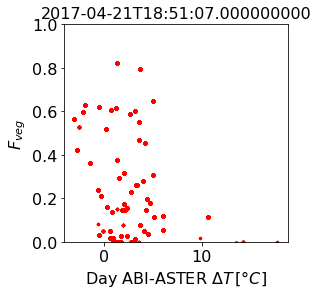

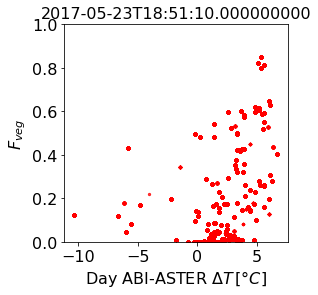

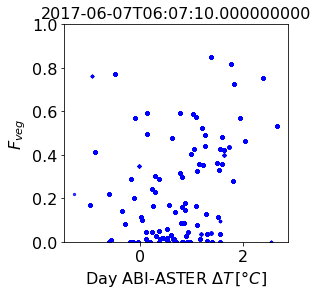

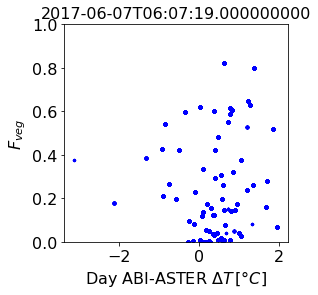

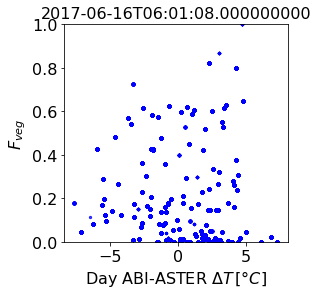

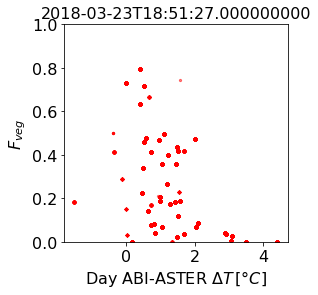

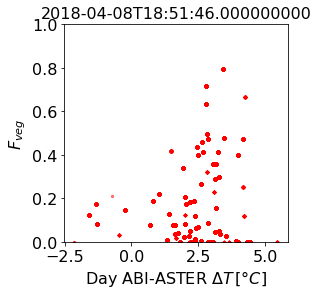

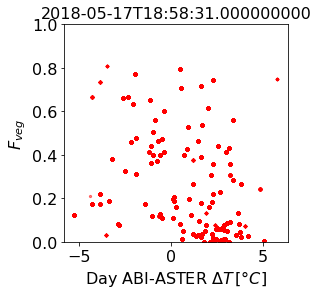

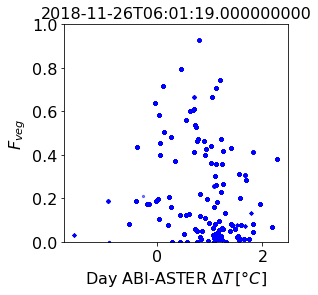

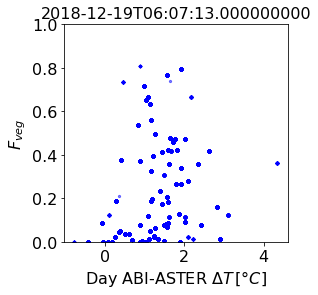

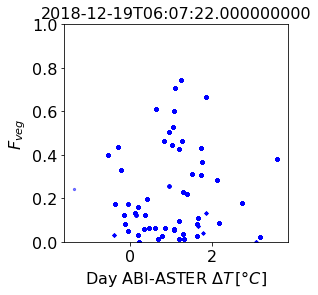

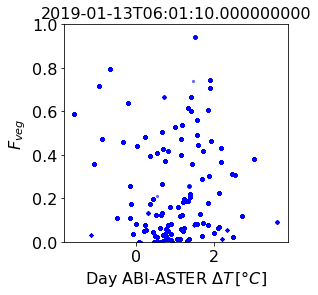

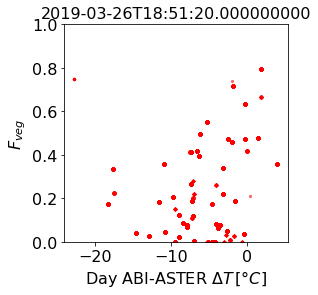

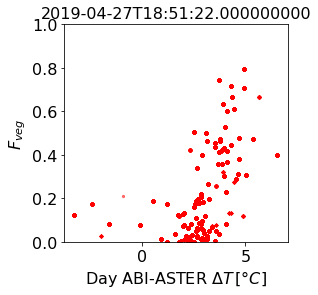

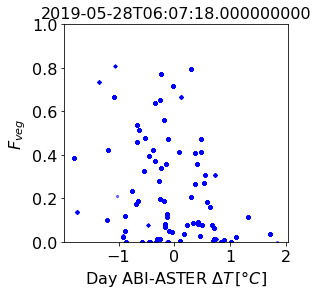

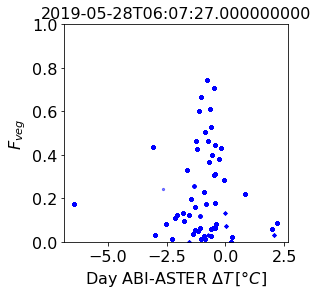

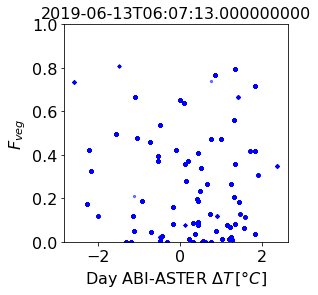

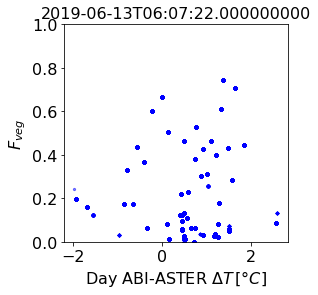

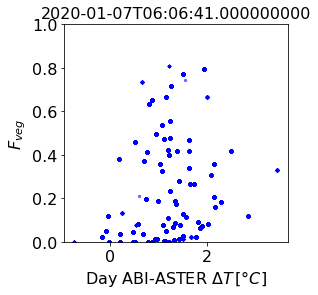

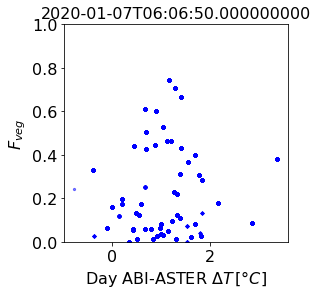

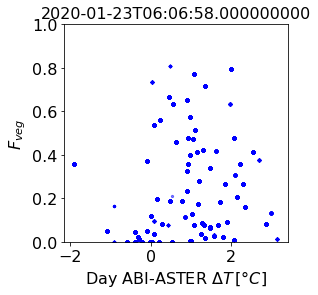

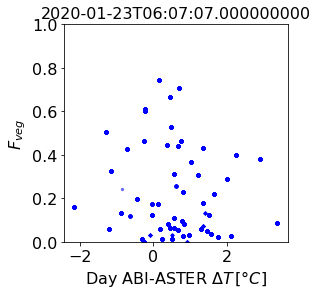

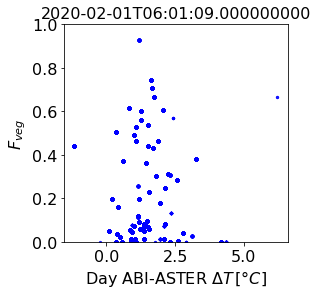

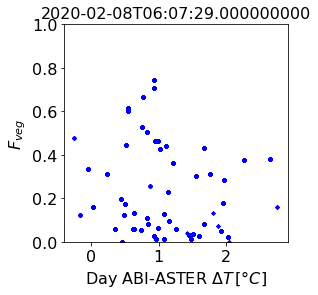

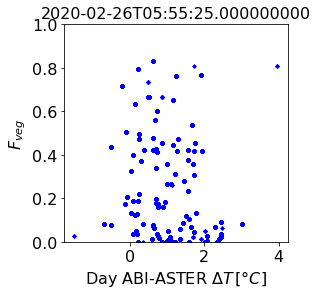

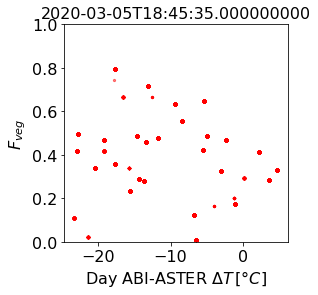

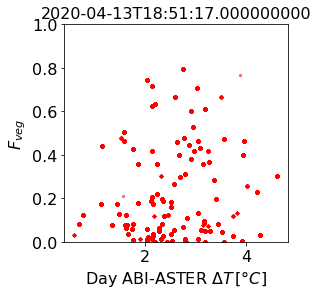

In [97]:
conf = 0.975

for i in range(0,len(ds.time)):

    this_ds = ds.isel(time=i)
    
    if this_ds.time.dt.hour  <= 6:
        c = 'b' # nighttime
    else:
        c = 'r' # daytime
    
    y = this_ds.fveg.values.ravel()
    
    
    ## MODIS-ASTER deltaT
    #x = this_ds.ast_mod_mean_diff_tb.mean(axis=0).values.ravel()
    #x0 = x#[y!=0]
    #y0 = y#[y!=0]
    #quick_plot2(x0,y0,'MODIS-ASTER $\Delta T\,[\degree C]$','$F_{veg}$', conf, False, c)
    #plt.ylim(0,1)
    #plt.xlim(-10,10)
    # ABI-ASTER deltaT
    x = this_ds.ast_goes_mean_diff_tb.values.ravel()
    x0 = x#[y!=0]
    y0 = y#[y!=0]
    quick_plot2(x0,y0,'Day ABI-ASTER $\Delta T\,[\degree C]$','$F_{veg}$', conf, False, c) #
    plt.title(this_ds.time.values)
    plt.ylim(0,1)
    #plt.xlim(-10,10)

0.02 	 0.78 	 0.08 	 0.0 	 0.0
-0.0 	 0.7 	 0.0 	 0.0 	 0.0
-0.12 	 0.58 	 0.04 	 0.0 	 0.0
-0.02 	 0.42 	 0.0 	 0.0 	 0.0
0.05 	 0.44 	 0.13 	 0.0 	 0.0
0.05 	 0.83 	 0.08 	 0.0 	 0.0
0.06 	 0.63 	 0.05 	 0.0 	 0.0
0.12 	 0.3 	 0.5 	 0.0 	 0.0
0.18 	 0.44 	 0.1 	 0.0 	 0.0
-0.15 	 0.9 	 0.13 	 0.0 	 0.0
-0.14 	 0.75 	 0.14 	 0.0 	 0.0
-0.04 	 0.58 	 0.01 	 0.0 	 0.0
-0.03 	 0.64 	 0.33 	 0.0 	 0.0
-0.05 	 0.95 	 0.07 	 0.0 	 0.0
nan 	 nan 	 nan 	 nan 	 nan
nan 	 nan 	 nan 	 nan 	 nan
nan 	 nan 	 nan 	 nan 	 nan
-0.04 	 0.32 	 0.01 	 0.0 	 0.0
-0.14 	 0.84 	 0.06 	 0.0 	 0.0
nan 	 nan 	 nan 	 nan 	 nan
-0.12 	 0.69 	 0.09 	 0.0 	 0.0
-0.02 	 0.59 	 0.01 	 0.0 	 0.0
-0.13 	 0.69 	 0.06 	 0.0 	 0.0
-0.03 	 0.44 	 0.0 	 0.0 	 0.0
0.15 	 0.29 	 0.1 	 0.0 	 0.0
0.01 	 0.4 	 0.11 	 0.0 	 0.0
-0.03 	 0.84 	 0.01 	 0.0 	 0.0


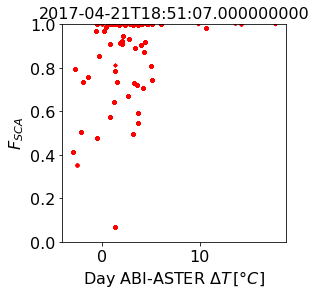

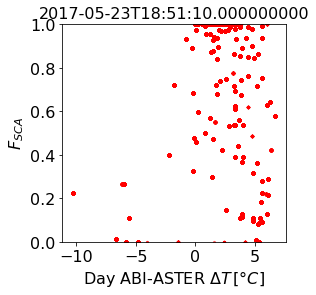

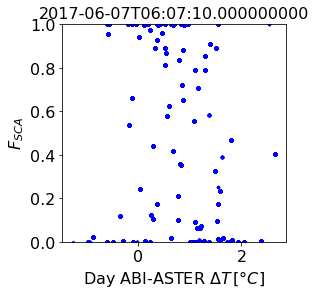

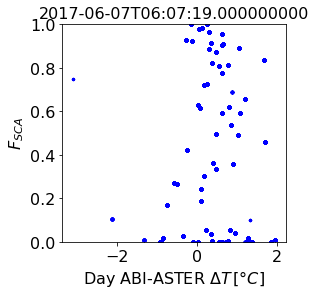

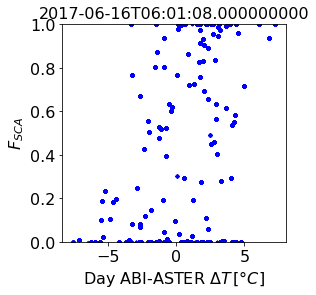

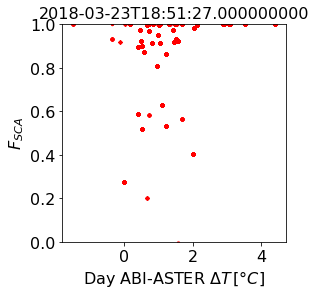

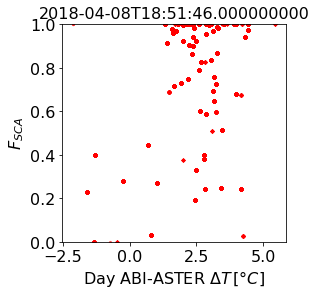

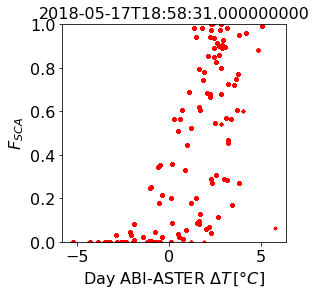

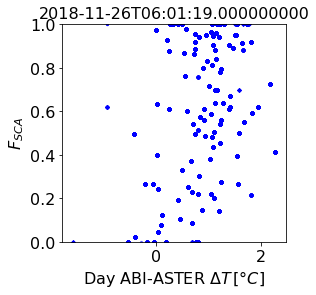

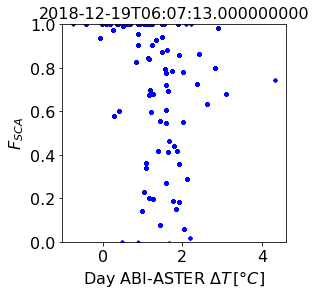

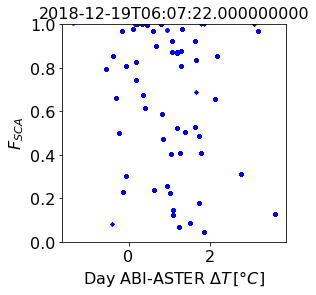

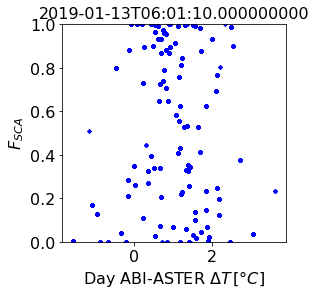

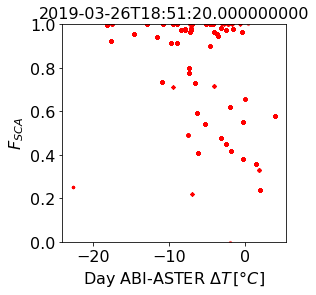

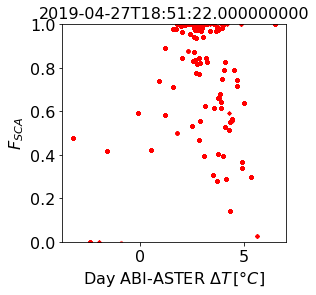

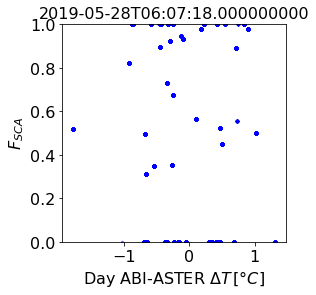

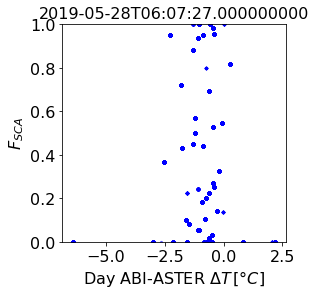

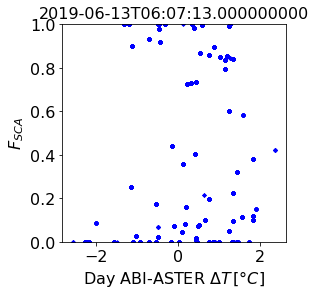

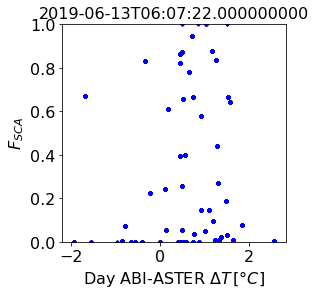

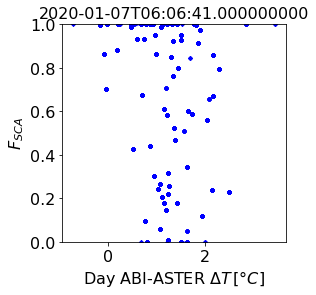

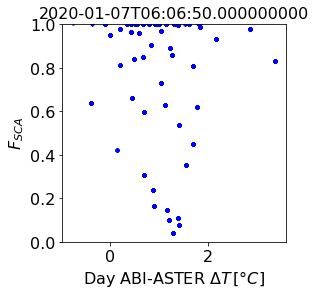

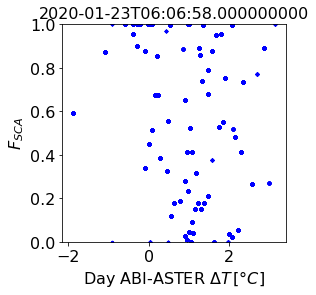

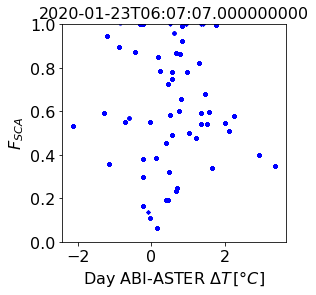

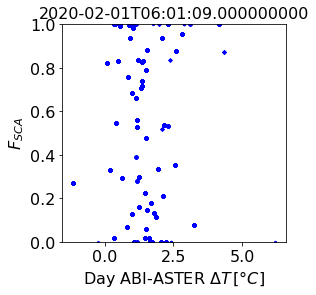

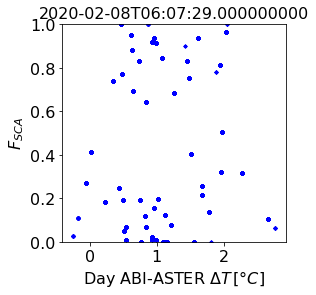

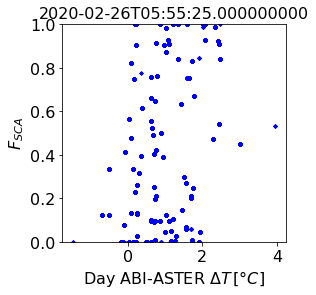

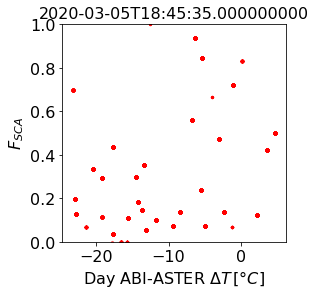

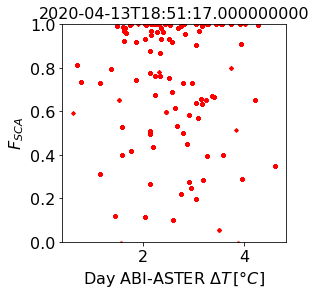

In [98]:
conf = 0.975

for i in range(0,len(ds.time)):

    this_ds = ds.isel(time=i)
    
    if this_ds.time.dt.hour  <= 6:
        c = 'b' # nighttime
    else:
        c = 'r' # daytime
    
    y = this_ds.fsca.values.ravel()
    
    
    ## MODIS-ASTER deltaT
    #x = this_ds.ast_mod_mean_diff_tb.mean(axis=0).values.ravel()
    #x0 = x#[y!=0]
    #y0 = y#[y!=0]
    #quick_plot2(x0,y0,'MODIS-ASTER $\Delta T\,[\degree C]$','$F_{veg}$', conf, False, c)
    #plt.ylim(0,1)
    #plt.xlim(-10,10)
    # ABI-ASTER deltaT
    x = this_ds.ast_goes_mean_diff_tb.values.ravel()
    x0 = x#[y!=0]
    y0 = y#[y!=0]
    quick_plot2(x0,y0,'Day ABI-ASTER $\Delta T\,[\degree C]$','$F_{SCA}$', conf, False, c) #
    plt.title(this_ds.time.values)
    plt.ylim(0,1)
    #plt.xlim(-10,10)

-0.73 	 1.04 	 0.74 	 0.0 	 0.0
-1.21 	 0.96 	 0.67 	 0.0 	 0.0
-1.5 	 0.82 	 0.64 	 0.0 	 0.0
-1.2 	 0.72 	 0.56 	 0.0 	 0.0
-1.36 	 0.74 	 0.57 	 0.0 	 0.0
-0.54 	 1.04 	 0.52 	 0.0 	 0.0
-0.95 	 0.96 	 0.51 	 0.0 	 0.0
-1.26 	 0.74 	 0.6 	 0.0 	 0.0
-0.85 	 0.81 	 0.34 	 0.0 	 0.0
-0.92 	 0.91 	 0.49 	 0.0 	 0.0
-1.21 	 0.92 	 0.67 	 0.0 	 0.0
-1.45 	 0.87 	 0.72 	 0.0 	 0.0
-0.99 	 1.04 	 0.82 	 0.0 	 0.0
-0.86 	 0.99 	 0.63 	 0.0 	 0.0
nan 	 nan 	 nan 	 nan 	 nan
nan 	 nan 	 nan 	 nan 	 nan
nan 	 nan 	 nan 	 nan 	 nan
-0.94 	 0.55 	 0.4 	 0.0 	 0.01
-1.38 	 0.97 	 0.77 	 0.0 	 0.0
nan 	 nan 	 nan 	 nan 	 nan
-1.36 	 0.88 	 0.73 	 0.0 	 0.0
-0.9 	 0.82 	 0.63 	 0.0 	 0.0
-1.45 	 0.86 	 0.77 	 0.0 	 0.0
-1.29 	 0.75 	 0.65 	 0.0 	 0.0
-1.33 	 0.76 	 0.69 	 0.0 	 0.0
-0.72 	 0.59 	 0.29 	 0.0 	 0.01
-1.12 	 1.02 	 0.82 	 0.0 	 0.0


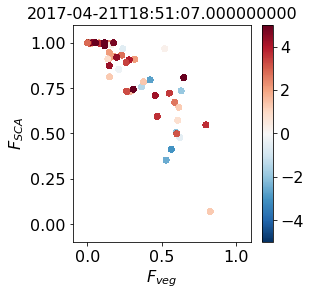

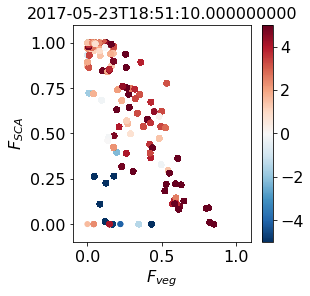

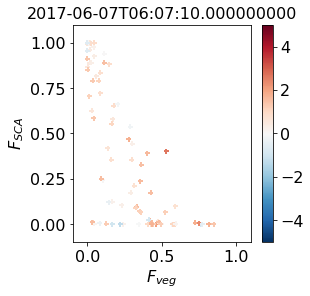

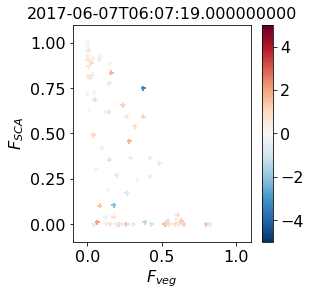

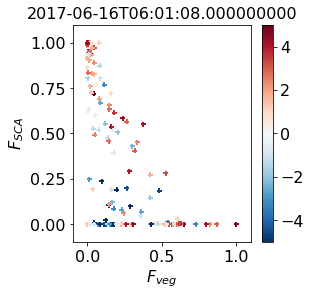

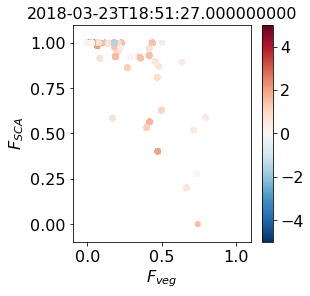

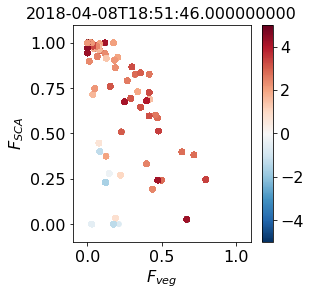

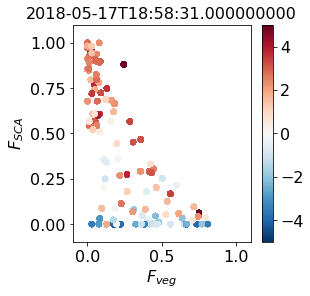

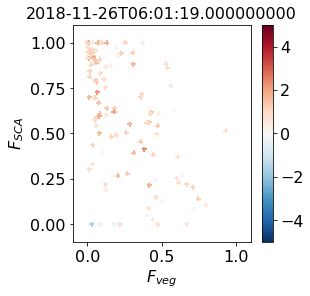

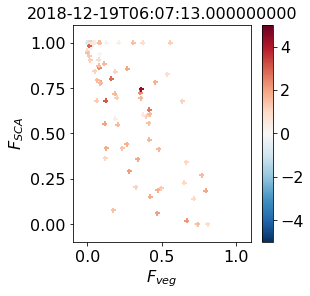

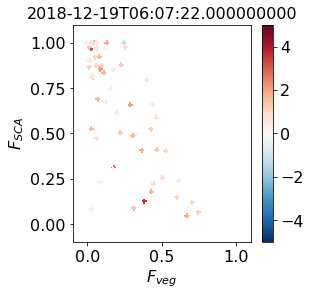

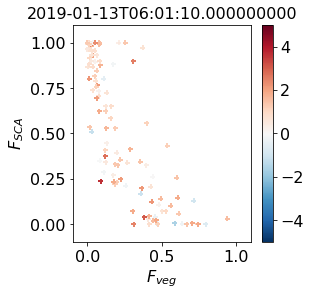

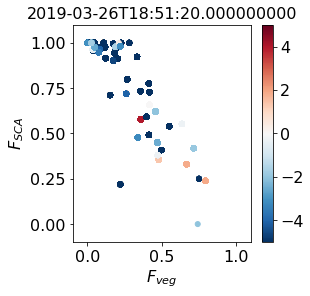

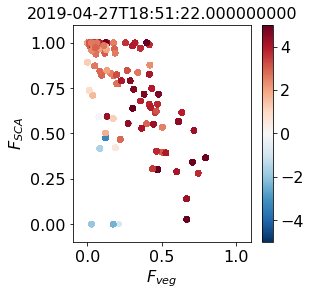

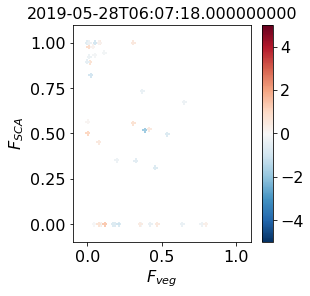

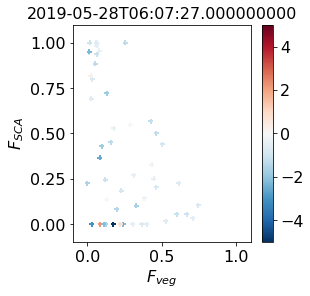

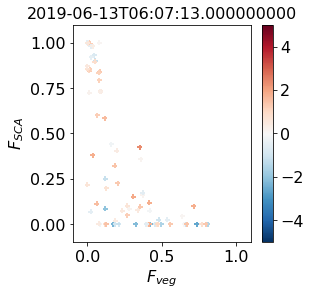

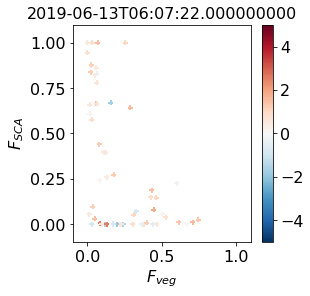

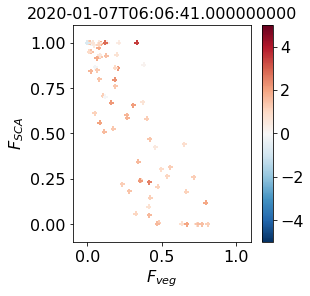

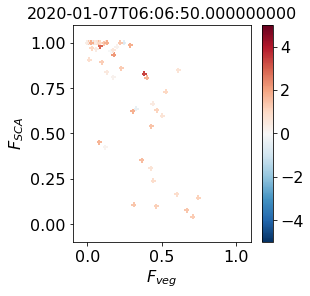

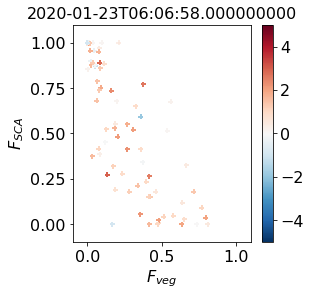

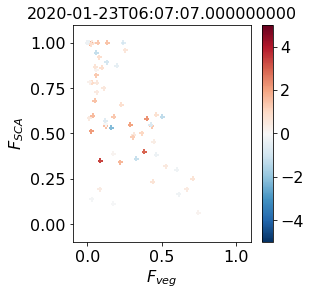

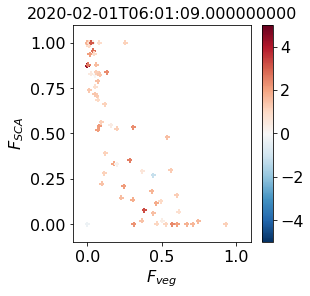

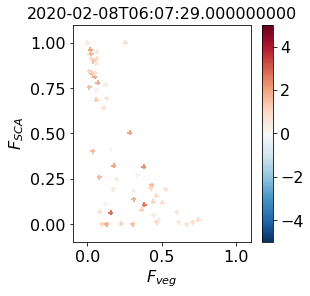

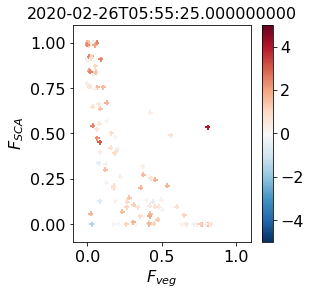

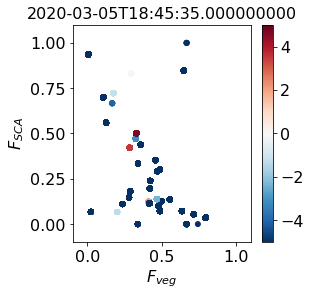

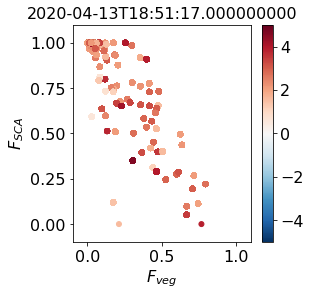

In [103]:
conf = 0.975

for i in range(0,len(ds.time)):

    this_ds = ds.isel(time=i)
    
    if this_ds.time.dt.hour <= 6:
        m = '+' # nighttime
    else:
        m = 'o' # daytime
    
    y = this_ds.fveg.values.ravel()
    y2 = this_ds.fsca.values.ravel()
    x = this_ds.ast_goes_mean_diff_tb.values.ravel()

    quick_plot2(y,y2,'$F_{veg}$','$F_{SCA}$', conf, False, x, m, 25, 'RdBu_r', -5, 5) #
    plt.title(this_ds.time.values)
    plt.ylim(-0.1,1.1)
    plt.xlim(-0.1,1.1)
    plt.colorbar()
    #plt.xlim(-10,10)

---
---

In [53]:
#from mpl_toolkits.mplot3d import Axes3D
#import matplotlib.pyplot as plt
#import numpy as np
#import random
#
## dummy variables for demonstration
#x = ds.ast_goes_mean_diff_tb.values.ravel()
#y = ds.fveg.values.ravel()
#z = np.array([hs_sat.values]*27).ravel()
#
## build the figure instance
#fig = plt.figure(figsize=(10,8))
#ax = fig.add_subplot(111, projection='3d')
#ax.scatter(x, y, z, c='k', marker='.', alpha=0.01)
#
## set your labels
#ax.set_xlabel('deltaT')
#ax.set_ylabel('Fveg')
#ax.set_zlabel('hs_sat')
#
#
#ax.view_init(20,135)
#
#plt.show()

---
---

In [54]:
#tree_height = 1
#lzas = np.arange(0,90,1)
#projected_tree_lengths = tree_height/np.tan(np.radians(90-lzas))
#plt.plot(lzas,projected_tree_lengths)